**Проект по предсказанию цены индеска S&P 500**

Все модели обучены на базе данных полученные через API Yahoo с даты 1982-04-20.
БД составлена во временном ряде, заглядывнием в прошлое на 30 дней, а предсказывает цену и тренд на следующей день.

Модели обучены на слоя Conv1d, Maxpuooing1d, Flatten, Dense

Гиперпарметры подобраны с помощью генетического алгоритма

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import * 

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# Коллбэк
from tensorflow.keras.callbacks import LearningRateScheduler

# Загрузка датасетов из облака google
import gdown

# Кодирование категориальных данных в формате OHE
from tensorflow.keras.utils import to_categorical

# random
import random

# функция ошибки для обучения нс
from tensorflow.keras.losses import MAE

# для отрисовки дерева слоев нс
from tensorflow.keras.utils import plot_model

# модуль подсчета времени
import time

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint

# Назначение размера и стиля графиков по умолчанию

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)
from keras.models import load_model

In [3]:
!pip install yfinance # Устанавливаем API для получения базы данных

     |████████████████████████████████| 6.4 MB 35.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import yfinance as yf
data = yf.download('^GSPC', start='1982-04-20')                                  # Получаем базу данных индекса S&P500 за каждый день с 1982г.
data_org = data.drop(['Adj Close','Volume'], 1)                                  # Удаляем не нужные колонны и делим на две базы
yahoo = data.drop('Adj Close', 1)                                                # Одна база для предсказания тренда другая для предсказания цены
yahoo['Volume'] = yahoo['Volume']/1000000                                        # Нормируем колонну 'Volume' так как она выбивается из общих данных
COL_CLOSE = 'Close'                                                              # Название колонны для предсказанных данных
# Настройка временного интервала для ограничения данных
TIME_RANGE = ('2015-08-01', '2022-12-31')
normaliz = data_org[COL_CLOSE].max()                                             # Назначаем максимальное число для дальнейшей нормализации базы данных тренда
mask = (data_org.index >= TIME_RANGE[0]) & (data_org.index <= TIME_RANGE[1])     # Создаем маску для 
dataVal = data_org[mask]

[*********************100%***********************]  1 of 1 completed


In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1982-04-20,115.800003,117.139999,114.830002,115.440002,115.440002,54610000
1982-04-21,115.480003,115.870003,115.300003,115.720001,115.720001,57820000
1982-04-22,115.720001,117.250000,115.720001,117.190002,117.190002,64470000
1982-04-23,118.019997,118.639999,117.190002,118.639999,118.639999,71840000
1982-04-26,118.940002,119.330002,118.250000,119.260002,119.260002,60500000
...,...,...,...,...,...,...
2022-04-14,4449.120117,4460.459961,4390.770020,4392.589844,4392.589844,3634740000
2022-04-18,4385.629883,4410.310059,4370.299805,4391.689941,4391.689941,3509340000
2022-04-19,4390.629883,4471.029785,4390.629883,4462.209961,4462.209961,3197930000


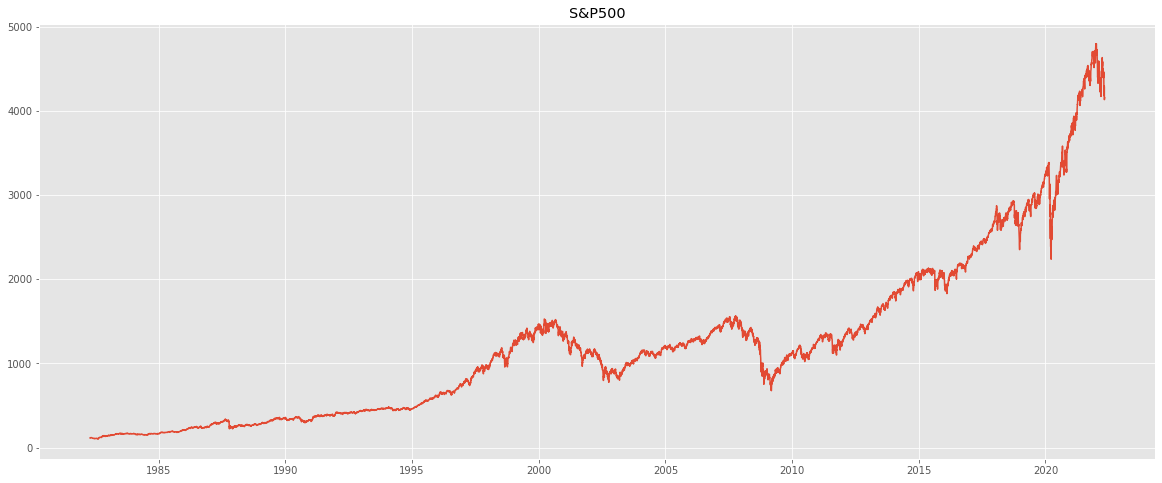

In [5]:
# Отображение временного ряда в графическом виде
plt.figure(figsize=(20, 8))
plt.plot(data_org.index, data_org[COL_CLOSE])
plt.title('S&P500')
plt.show()

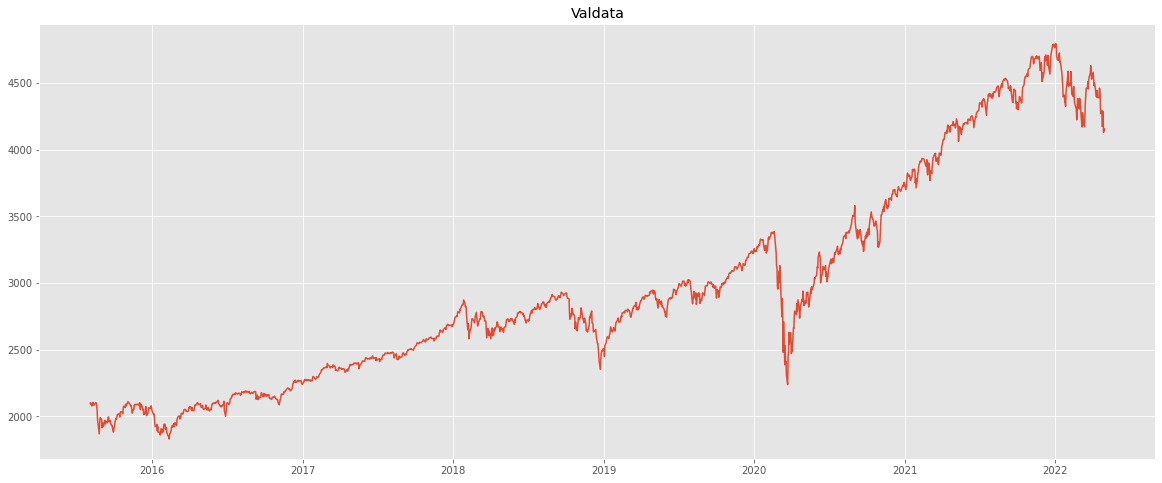

In [6]:
# Отображение временного ряда проверочной выборки в графическом виде
plt.figure(figsize=(20, 8))
plt.plot(dataVal.index, dataVal[COL_CLOSE])
plt.title('Valdata')
plt.show()

In [7]:
INDICATOR_DEPTH = 30                      # для базыданных тренда, заглядываени на сколько дней назад
SEQ_LEN = 30                              # Длина серии (подпоследовательности) входных данных для анализа
PREDICT_LAG = 1                           # Количество шагов в будущее для предсказания
TEST_LEN = 600

In [8]:
# Функция разделения набора данных на выборки для обучения нейросети 
# x_data - набор входных данных
# y_data - набор выходных данных
# seq_len - длина серии (подпоследовательности) входных данных для анализа
# predict_lag - количество шагов в будущее для предсказания
def split_sequence(x_data, y_data, seq_len, predict_lag):
    # Определение максимального индекса начала подпоследовательности
    x_len = x_data.shape[0] - seq_len - (predict_lag - 1)
    # Формирование подпоследовательностей входных данных
    x = [x_data[i:i + seq_len] for i in range(x_len)]
    # Формирование меток выходных данных, 
    # отстоящих на predict_lag шагов после конца подпоследовательности
    y = [y_data[i + seq_len + predict_lag - 1] for i in range(x_len)]
    # Возврат результатов в виде массивов numpy
    return np.array(x), np.array(y)

In [9]:
# Расчет индикаторов относительной доходности
train = []                                                                      # База данных для обучение в списке. Тренд
valx = []                                                                       # БД для теста входные
valy = []                                                                       # БД для теста выходные

dataT = data_org.copy()                                                         # Копируем базу данных чтоб была возможность восстановить
dataV = dataVal.copy()
for i in range(1, INDICATOR_DEPTH + 1):                                         # Прозодимся по таблицы для создание БД Тренд
    indicator_change = f'Close_chng_{i}'
    # Относительная доходность в сотых долях за период i шагов назад
    dataT[indicator_change] = data_org[COL_CLOSE].pct_change(i)
    dataV[indicator_change] = dataVal[COL_CLOSE].pct_change(i)
    if i == INDICATOR_DEPTH:
      dataT.dropna(inplace=True)                                                # Чистим БД от пропусков(пустых) данных
      dataV.dropna(inplace=True)
      '''for i in range(1, ind + 1):
          indicator_change = f'Close_chng_{i}'
          indicator_trend = f'Y_{i}'
          # Заполнение столбца индикатора тренда нулями (нисходящий/боковой тренд)
          dataT[indicator_trend] = 0.
          dataV[indicator_trend] = 0.
          # Если индикатор изменения периода на i шагов положителен, то тренд восходящий
          dataT.loc[dataT[indicator_change] > 0. , indicator_trend] = 1.
          dataV.loc[dataV[indicator_change] > 0. , indicator_trend] = 1.'''
      dataT[COL_CLOSE] = dataT[COL_CLOSE]/normaliz                              # Нормализуем выходные данные по максимальному значению
      dataV[COL_CLOSE] = dataV[COL_CLOSE]/normaliz
      x_col = [COL_CLOSE] + [f'Close_chng_{i}' for i in range(1, INDICATOR_DEPTH + 1)] # Создаем колонны которые будут входить в БД
      dataTa = dataT[x_col].values
      dataVa = dataV[x_col].values
      indicator_name = f'Close_chng_{INDICATOR_DEPTH}'                           # Колона которая будет входить в выходные данные
      y_class = dataT[indicator_name]  
      #y_data = to_categorical(y_class)
      y_val = dataV[indicator_name] 
      x_train_data, y_train_data = dataTa[:-TEST_LEN-SEQ_LEN], y_class[:-TEST_LEN-SEQ_LEN]  # Делим БД на обучающуюся и проверочную
      x_test_data, y_test_data = dataTa[-TEST_LEN:], y_class[-TEST_LEN:] 
      x_train, y_train = split_sequence(x_train_data, y_train_data, seq_len=SEQ_LEN, predict_lag=PREDICT_LAG) # Создаем БД временного ряда с заглядываение в прошлое на 30 дней последовательно каждый день
      x_test, y_test = split_sequence(x_test_data, y_test_data, seq_len=SEQ_LEN, predict_lag=PREDICT_LAG)
      xVal, yVal = split_sequence(dataVa, y_val, seq_len=SEQ_LEN, predict_lag=PREDICT_LAG)   
      train.append([x_train, y_train, x_test, y_test])
      valx.append(xVal)
      valy.append(yVal)
valy = np.reshape(valy, (-1,1))                                                 # Решейп для подачи в модель на выход
valx = valx[0]                                                                  # Выводим из списка тестовые входные данные
train = train[0]                                                                # Выводим из списка БД для обучения train[0] - входные обучеине, train[1] - выходные обучение, train[2] - входные проверочная, train[3] - выходные проверочная

In [10]:
data = np.array(yahoo)                                                          # Перевод таблицы в массив
dataTrend = np.array(dataTa)                                                    # Для проверки предсказания

In [11]:
train[0].shape

(9405, 30, 31)

In [12]:
# Формирование параметров загрузки данных

xLen = 30       # Анализ по 30 прошедшим точкам 
valLen = 1000  # Использование 500 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

# Деление данных на тренировочную и тестовую выборки 
xTrain,xVal,xTest  = data[:trainLen], data[trainLen+xLen+2:-300], data[-300:]

# Масштабирование данных 
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)
xVal = xScaler.transform(xVal)

# Преобразование размерности,т. к. используется один столбец по одному значению
yTrain,yVal, yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:-300,3],(-1,1)), np.reshape(data[-300:,3],(-1,1))

yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)
yVal = yScaler.transform(yVal)

# Создание генератора для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain, # обучающая выборка    
                                   length=xLen, # для каждой точки из xLen
                                   stride=4, # на сколько элементов сдвиг
                                   batch_size=10) # сколько элементов вернет генератор)              

# Создание аналогичного генератора для валидации при обучении
testDataGen = TimeseriesGenerator(xVal, yVal, # проверочная выборка
                                  length=xLen, # для каждой точки из xLen
                                  stride=4, # на сколько элементов сдвиг
                                  batch_size=10) # сколько элементов вернет генератор)

In [13]:
# Создание генератора тестовой выборки
DataGen = TimeseriesGenerator(xTest, yTest, # Выборки
                               length=xLen, # для каждой точки из xLen
                               stride=4, # размер шага при выборке xTest
                               batch_size=len(xTest) # сколько элементов вернет генератор
                               ) 

xTest, yTest = DataGen[0][0], DataGen[0][1]


In [14]:
inputShapeT = train[0][0].shape                                                 # Размерность входных данных для модели Тренд
print(inputShapeT)
outputShape = trainDataGen[0][1][0].shape                                       # Размерность выходных данных для модели
print(outputShape)
inputShape = trainDataGen[0][0][0].shape                                        # Размерность входных данных для модели предсказания цены
print(inputShape)

(30, 31)
(1,)
(30, 5)


In [15]:
def get_predT(currModel, 
             xVal, 
             yVal):
  '''
  Функция рассчитываем результаты прогнозирования сети
  В аргументы принимает сеть (currModel) и проверочную выборку
  Выдаёт результаты предсказания predVal
  И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
  '''
  
  # Вычисление и деномализация предсказания
  #predVal = yScaler.inverse_transform(currModel.predict(xVal))
  predVal = currModel.predict(xVal)
  # Денормализация верных ответов
  #yValUnscaled = yScaler.inverse_transform(yVal)
  yValUnscaled = yVal
  # И возвращаем исходны масштаб данных, до нормализации
  return (predVal, yValUnscaled)

def get_pred(currModel, 
             xVal, 
             yVal, 
             yScaler):
  '''
  Функция рассчитываем результаты прогнозирования сети
  В аргументы принимает сеть (currModel) и проверочную выборку
  Выдаёт результаты предсказания predVal
  И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
  '''
  
  # Вычисление и деномализация предсказания
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  
  # Денормализация верных ответов
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  # И возвращаем исходны масштаб данных, до нормализации
  return (predVal, yValUnscaled)


# Функция расёта корреляции дух одномерных векторов

def correlate(a, 
              b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val # аналог функции в нампи np.corrcoef(a, b)[0, 1]


def show_predict(start, 
                 step, 
                 channel, 
                 predVal, 
                 yValUnscaled):
  '''
  Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
  start - точка с которой начинаем отрисовку графика
  step - длина графика, которую отрисовываем
  channel - какой канал отрисовываем
  '''
  
  plt.figure(figsize=(16, 10))
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  


def auto_corr(channels, corrSteps, predVal, yValUnscaled, plot_graf = True, return_data = False):
  '''
  Функция рисуем корреляцию прогнозированного сигнала с правильным
  Смещая на различное количество шагов назад
  Для проверки появления эффекта автокорреляции
  channels - по каким каналам отображать корреляцию
  corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
  showGraf - показываем график или нет
  returnData - возвращаем массивы автокорреляции или нет
  '''
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if plot_graf: #Если нужно показать график
      plt.figure(figsize=(12, 5))
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if plot_graf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if return_data: #Если нужно вернуть массивы автокорреляции
     return corr, own_corr

In [16]:
#Создаём сеть (net - список параметров)
def create_randnet(net, xLen, channels, num_cls, control_level_shape = 10**5):
  '''
  net - полученный бот со списком значений для формирования сети
  xLen - размер анализируемых данных до предсказания
  channels - количество каналов данных
  num_cls - количество предсказываемых шагов
  control_level_shape - парамметр при превышению которого будет применен 
                        слой GlobalAveragePooling1D, а не Flatten
  '''
  

  model = Sequential()             # Создаем моель Sequential

  '''
  Присвоение значений параметрам слоев из значений полученного бота
 
  Входной блок
  '''
  makeFirstNormalization = net[0]  # Делаем ли нормализацию в начале
  firstConvSize = 2 ** net[1]      # Размер первого вёрточного слоя
  firstConvKernel = net[2]         # Ядро первого свёрточного слоя
  activation0 = net[3]             # Функция активации входного слоя
  makeMaxPooling0 = net[4]         # Делаем ли maxpooling для нулевого слоя
  maxPoolingSize0 = net[5]         # Размер MaxPooling

  '''
  Первый скрытый Conv блок
  '''
  makeSecondConv = net[6]          # Делаем ли второй свёрточный слой
  secondConvSize = 2 ** net[7]     # Размер второго свёрточного слоя
  secondConvKernel = net[8]        # Ядро второго свёрточного слоя
  makeMaxPooling1 = net[9]         # Делаем ли MaxPooling
  maxPoolingSize1 = net[10]        # Размер MaxPooling
  activation1 = net[11]            # Функция активации

  '''
  Второй скрытый Conv блок
  '''
  makeThirdConv = net[12]          # Делаем ли второй свёрточный слой
  thirdConvSize = 2 ** net[13]     # Размер второго свёрточного слоя
  thirdConvKernel = net[14]        # Ядро второго свёрточного слоя
  makeMaxPooling2 = net[15]        # Делаем ли MaxPooling
  maxPoolingSize2 = net[16]        # Размер MaxPooling
  activation2 = net[17]            # Функция активации

  '''
  Третий скрытый dense блок
  '''
  makeDense = net[18]              # Делаем ли Dense до Flatten 
  denseSize0 = 2 ** net[19]        # Размер полносвязного слоя 
  activationdense0 = net[20]       # Функция активации

  '''
  Выходной dense блок
  '''
  denseSize1 = 2 ** net[21]        # Размер предпоследнего полносвязного слоя 
  activationdense1 = net[22]       # Функция активации предпоследнего полносвязного слоя 
  makeSecondNormalization = net[23]  # Делаем ли нормализацию в начале
  #activationdense2 = net[24]       # Функция активации дпоследнего полносвязного слоя 

  '''
  Список активационных функций
  '''
  activation_list = ['linear','relu', 'elu', 'selu' ,'tanh'] 


  '''
  Условия для формирования блоков
  _______________________________

  Входной Conv блок
  '''
  # Если делаем нормализацию в начале
  if (makeFirstNormalization):      
      # Добавляем слой BatchNormalization
      model.add(BatchNormalization(input_shape=(xLen, channels))) 

      # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
      model.add(Conv1D(firstConvSize, firstConvKernel,
      activation=activation_list[activation0], padding='same')) 

  else:
      # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
      model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, channels),
                      activation=activation_list[activation0], padding='same')) 
      # Если делаем maxpooling
  if makeMaxPooling0:               
      model.add(MaxPooling1D(maxPoolingSize0))

  '''
  Первый скрытый Conv блок
  '''
  # Если делаем второй свёрточный слой
  if (makeSecondConv):              
      # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
      model.add(Conv1D(secondConvSize, secondConvKernel,
                      activation=activation_list[activation1], padding='same')) 
      
      # Если делаем MaxPooling
      if (makeMaxPooling1):           
        # Добавляем слой MaxPooling1D с размером (maxPoolingSize)
        model.add(MaxPooling1D(pool_size=maxPoolingSize1)) 

  '''
  Второй скрытый Conv блок
  '''
  # Если делаем второй свёрточный слой
  if (makeThirdConv):               
      # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
      model.add(Conv1D(thirdConvSize, thirdConvKernel,
                      activation=activation_list[activation2], padding='same')) 
      # Если делаем MaxPooling
      if (makeMaxPooling2):           
          # Добавляем слой MaxPooling1D с размером (maxPoolingSize, maxPoolingSize)
          model.add(MaxPooling1D(pool_size=maxPoolingSize2)) 

  '''
  Третий скрытый dense блок
  '''
  # Если делаем Dense до Flatten() или GlobalAveragePooling1D()
  if (makeDense):
      model.add(Dense(denseSize0, activation=activation_list[activationdense0]))

  '''
  Блок проверки размерности слоя
  Для применения Flatten() или GlobalAveragePooling1D()
  для вытягивания в вектор значений и передачи в выходной блок из Dense слоев
  '''
  # Получаем размерность последнего из добавленных слоев
  control_shape = model.layers[-1].output.get_shape()

  # Сравниваем с контрольным значением и применяем слой по условию
  if control_shape[-1]*control_shape[-2] < control_level_shape:
      model.add(Flatten())                   # Добавляем слой Flatten
  else: model.add(GlobalAveragePooling1D())  # Добавляем слой GlobalAveragePooling1D
 
  '''
  Выходной dense блок
  '''
  # Если делаем финальную нормализацию         
  if (makeSecondNormalization):     
      model.add(BatchNormalization()) # Добавляем слой BatchNormalization
  # Добавляем слой Dense с denseSize нейронами  
  model.add(Dense(denseSize1, activation=activation_list[activationdense1])) 
  # Добавляем Dense-слой с softmax-активацией и 10 нейронами
  model.add(Dense(num_cls, activation=activation_list[0]))   
  
  # Возвращаем модель
  return model    

In [17]:
def create_bot4net():
  '''
  Функция создания списка случайных параметров
  '''

  net = []
  '''
  Входной Conv блок
  '''
  net.append(random.randint(0,1)) # 0 Делаем или нет нормализацию 
  net.append(random.randint(3,10)) # 1 Первый свёрточный слой от 4 до 1024 
  net.append(random.randint(2,5)) # 2 Ядро первого свёрточного слоя от 2 до 7
  net.append(random.randint(0,4)) # 3 Функция активации первого слоя
  net.append(random.randint(0,1)) # 4 Делаем ли MaxPooling
  net.append(random.randint(1,4)) # 5 Размер MaxPooling

  '''
  Первый скрытый Conv блок
  '''
  net.append(random.randint(0,1)) # 6 Сколько делаем еще сверточных слоев
  net.append(random.randint(3,10)) # 1 Первый свёрточный слой от 4 до 1024 
  net.append(random.randint(2,5)) # 8 Ядро второго свёрточного слоя от 2 до 8
  net.append(random.randint(0,1)) # 9 Делаем ли MaxPooling
  net.append(random.randint(1,4)) # 10 Размер MaxPooling
  net.append(random.randint(0,4)) # 11 Функция активации второго слоя

  '''
  Второй скрытый Conv блок
  '''
  net.append(random.randint(0,1)) # 12 Сколько делаем еще сверточных слоев
  net.append(random.randint(3,10)) # 1 Первый свёрточный слой от 4 до 1024 
  net.append(random.randint(2,5)) # 14 Ядро второго свёрточного слоя от 2 до 8
  net.append(random.randint(0,1)) # 14 Делаем ли MaxPooling
  net.append(random.randint(1,3)) # 16 Размер MaxPooling
  net.append(random.randint(0,4)) # 17 Функция активации второго слоя

  '''
  Третий скрытый dense блок
  '''
  net.append(random.randint(0,1)) # 18 Делаем ли Dense до Flatten 
  net.append(random.randint(2,10)) # 19 Размер полносвязного слоя 
  net.append(random.randint(0,4)) # 20 Функция активации

  '''
  Выходной dense блок
  '''
  net.append(random.randint(2,10)) # 21 Размер полносвязного слоя от 4 до 1024
  net.append(random.randint(0,4)) # 22 Функция активации предпоследнего dense слоя
  net.append(random.randint(0,1)) # 23 Делаем ли финальную нормализацию слой
  #net.append(0) # 24 Функция активации последнего слоя
  
  return net

Создадим случаного бота функцией `createRandomNet()` и подадим в функцию формирования сети из бота - `createConvNet`

In [ ]:
bot = create_bot4net()
print(bot)
print('Длина бота', len(bot))
# Создаем модель createConvNet
model = create_randnet(bot,
                      inputShape[0], # количество подаваемых шагов в наборе
                      inputShape[1], # количество каналов данных в наборе
                      outputShape[0] # на сколько предсказываем 
                      )
# выводим слои модели 
model.summary()                               

[1, 9, 2, 1, 0, 3, 1, 5, 3, 1, 4, 0, 1, 3, 2, 1, 2, 2, 1, 5, 1, 8, 1, 1]
Длина бота 24
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 5)            20        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 30, 512)           5632      
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 32)            49184     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 32)            0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 8)              520       
                                   

In [18]:
def eval_netT(net, ep, verb, xData, yData, xVal, yVal, xLen, channels, num_cls, x_test, y_test):
  '''
  Функция вычисления результата работы сети
  '''
  val = 0
  model = create_randnet(net, xLen,  channels, num_cls) # Создаем модель createConvNet
  
  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse')
  print('Обучение модели бота', net)
  history = model.fit(xData, yData,
                    epochs=ep, 
                    verbose=verb,
                    validation_data=(xVal, yVal))
    

  # Прогнозируем данные текущей сетью
  y_pred, y_true = get_predT(model, x_test, y_test) #Прогнозируем данные

  print('Сохранение оценки бота') 
  # Возвращаем автокорреляцию 
  corr, own_corr = auto_corr([0], 5, y_pred, y_true, plot_graf = False, return_data = True)
  val = MAE(corr, own_corr).numpy() * np.median(history.history["val_loss"])# Считаем MAE и прибавляем ошибку
  
  return val                      # Возвращаем точность

In [19]:
def eval_net(net, ep, verb, xData, yData, xLen, channels, num_cls, x_test, y_test, Scaler):
  '''
  Функция вычисления результата работы сети
  '''
  val = 0
  model = create_randnet(net, xLen,  channels, num_cls) # Создаем модель createConvNet
  
  # Компилируем модель
  model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse')
  print('Обучение модели бота', net)
  history = model.fit(xData,
                    epochs=ep, 
                    verbose=verb,
                    validation_data=yData)
    

  # Прогнозируем данные текущей сетью
  y_pred, y_true = get_pred(model, x_test, y_test, Scaler) #Прогнозируем данные

  print('Сохранение оценки бота') 
  # Возвращаем автокорреляцию 
  corr, own_corr = auto_corr([0], 5, y_pred, y_true, plot_graf = False, return_data = True)
  val = MAE(corr, own_corr).numpy() * np.median(history.history["val_loss"])# Считаем MAE и прибавляем ошибку
  
  return val                      # Возвращаем точность

In [ ]:
eval_netT(bot,            # бот популяции Тренд
                    2,              # к-во эпох проверки 
                    1,              # выводить или нет процесс обучения 
                    train[0],  # тренировочные данные
                    train[1],
                    train[2],         # тестовая выборка
                    train[3],    # проверочные данные
                    inputShapeT[0],  # количество подаваемых шагов в наборе
                    inputShapeT[1],  # количество каналов данных в наборе
                    outputShape[0], # на сколько предсказываем 
                    valx,         # тестовая выборка
                    valy) 

Обучение модели бота [1, 9, 2, 1, 0, 3, 1, 5, 3, 1, 4, 0, 1, 3, 2, 1, 2, 2, 1, 5, 1, 8, 1, 1]
Epoch 1/2
294/294 [==============================] - 12s 35ms/step - loss: 0.0229 - val_loss: 0.0161
Epoch 2/2
294/294 [==============================] - 13s 46ms/step - loss: 0.0046 - val_loss: 0.0066
Сохранение оценки бота


0.007529136332512702

In [ ]:
eval_net(bot,            # бот популяции Предсказания цены
            2,              # к-во эпох проверки 
            1,              # выводить или нет процесс обучения 
            trainDataGen,  # тренировочные данные
            testDataGen,    # проверочные данные
            inputShape[0],  # количество подаваемых шагов в наборе
            inputShape[1],  # количество каналов данных в наборе
            yTest.shape[1], # на сколько предсказываем 
            xTest,         # тестовая выборка
            yTest,         # тестовая выборка
            yScaler        # скейлер данных
            )

Обучение модели бота [1, 9, 2, 1, 0, 3, 1, 5, 3, 1, 4, 0, 1, 3, 2, 1, 2, 2, 1, 5, 1, 8, 1, 1]
Epoch 1/2
227/227 [==============================] - 4s 12ms/step - loss: 0.0551 - val_loss: 0.7355
Epoch 2/2
227/227 [==============================] - 2s 10ms/step - loss: 0.0264 - val_loss: 4.8147
Сохранение оценки бота


0.42223776105668304

In [ ]:
'''
Основные параметры для поиска для модели предсказания тренда
'''
n = 25              # Общее число ботов
nsurv = 5           # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 24              # Размер бота
epohs = 20          # количество эпох поиска
control_std = 0.000001 # выход из поиска если изменение в лучших ниже данного значения


'''
Изменении показателя мутации по эпохам поиска
'''
mut = 0.5        # коэфициент мутаций
eph_change_mut = [2, 4, 6, 8] # эпохи смены коэфициента мутации
new_mut = [0.4, 0.3, 0.2, 0.1] # новый коэфициент мутаци


'''
Создаём популяцию случайных ботов
'''
popul = []         # Массив популяции
val = []           # Одномерный массив значений этих ботов
for i in range(n):
    popul.append(create_bot4net())


'''
Основной цикл поиска
'''  
sval_best = []    # Одномерный массив значений лучших ботов на эпохах
# Пробегаем по всем эпохам
for it in range(epohs):                 
    # проверяем текущую эпоху it на принадлежность графику смены мутации
    if it in eph_change_mut:
        idx = eph_change_mut.index(it) # получаем индекс  по эпохе
        mut = new_mut[idx] # проверяем текущую эпохуобновляем мутацию
        print('Смена мутации на', mut)
        print()  

    val = []                              # Обнуляем значения бота
    curr_time = time.time()               # засекаем время

    '''
    Получение оценок ботов
    '''  
    # Пробегаем в цикле по всем ботам 
    for i in range(n):                    
        bot = popul[i]                     # Берем очередного бота

        # Вычисляем точность текущего бота
        f = eval_netT(bot,            # бот популяции 
                    5,              # к-во эпох проверки 
                    0,              # выводить или нет процесс обучения 
                    train[0],  # тренировочные данные
                    train[1],
                    train[2],         # тестовая выборка
                    train[3],    # проверочные данные
                    inputShapeT[0],  # количество подаваемых шагов в наборе
                    inputShapeT[1],  # количество каналов данных в наборе
                    outputShape[0], # на сколько предсказываем 
                    valx,         # тестовая выборка
                    valy)  
        val.append(f)   # Добавляем полученное значение в список val
    
    '''
    Сортировка оценок ботов и контроль поиса
    ''' 
    sval = sorted(val, reverse=0)         # Сортируем val
    # Выводим 5 лучших ботов
    print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 

    sval_best.append(sval[0])             # добавляем значение лучшего бота
    # проверка на продолжение поиска, есть разница или уже нет в точности
    if it > 7:                            # с 8й эпохи 
        sval_best = sorted(sval_best, reverse=0)[:5] # сортируем и берем 5ть лучших 
        if np.std(sval_best) < control_std:          # сверяем значения на отличие 
            print('Поиск лучших не дает нового, выход')
            break

    '''
    Сохранение лучших ботов в newpopul
    '''  
    newpopul = [] # Создаем пустой список под новую популяцию
    # Пробегаем по всем выжившим ботам
    for i in range(nsurv):
        # Получаем индекс очередного бота из списка лучших в списке val             
        index = val.index(sval[i])
        # Добавляем в новую популяцию бота из popul с индексом index        
        newpopul.append(popul[index])       
    '''
    Создание новых ботов на основе лучших ботов в newpopul.
    Иногда дополнительно применение мутации
    '''
    # Проходимся в цикле nnew-раз 
    for i in range(nnew):
        # случайный выбор родителя в диапазоне от 0 до nsurv - 1              
        indexp1 = random.randint(0,nsurv-1) # Случайный индекс 1го родителя 
        indexp2 = random.randint(0,nsurv-1) # Случайный индекс 1го родителя
        botp1 = newpopul[indexp1]           # бота-родителя 1 по indexp1
        botp2 = newpopul[indexp2]           # бота-родителя  2 по indexp2    
        newbot = []                         # пустой список для нового бота    
        net4Mut = create_bot4net()         # Создаем случайную сеть для мутаций

        '''
        Пробегаем по всей длине бота
        '''
        for j in range(l):                        
            x = 0      

            '''
            Скрещмивание
            '''
            # Получаем случайное число в диапазоне от 0 до 1
            pindex = random.random() 
            # Если pindex меньше 0.5, то берем значения от 1 бота, иначе от 2
            if pindex < 0.5:
                x = botp1[j]
            else:
                x = botp2[j]
            
            '''
            Мутация
            '''
            # С вероятностью mut устанавливаем значение бота из net4Mut
            if (random.random() < mut):
                x = net4Mut[j]
              
            newbot.append(x)    # Добавляем очередное значение в нового бота      
        newpopul.append(newbot) # Добавляем бота в новую популяцию      
    popul = newpopul            # Записываем в popul новую посчитанную популяцию

Обучение модели бота [0, 4, 5, 0, 0, 4, 1, 8, 5, 1, 1, 0, 0, 3, 4, 1, 3, 4, 0, 8, 3, 8, 3, 0]
Сохранение оценки бота
Обучение модели бота [0, 5, 2, 0, 1, 4, 0, 6, 2, 1, 4, 0, 0, 5, 4, 1, 1, 1, 1, 7, 0, 2, 1, 1]
Сохранение оценки бота
Обучение модели бота [0, 7, 4, 4, 0, 2, 0, 6, 5, 0, 1, 0, 0, 4, 4, 1, 3, 2, 1, 6, 2, 9, 1, 1]
Сохранение оценки бота
Обучение модели бота [1, 9, 2, 0, 0, 1, 1, 4, 5, 1, 3, 2, 0, 4, 4, 0, 3, 0, 0, 10, 1, 10, 0, 1]
Сохранение оценки бота
Обучение модели бота [0, 6, 5, 3, 1, 1, 0, 5, 4, 0, 2, 0, 1, 10, 3, 0, 3, 3, 0, 3, 0, 2, 4, 0]
Сохранение оценки бота
Обучение модели бота [0, 4, 2, 3, 1, 4, 0, 4, 2, 1, 4, 3, 0, 5, 2, 1, 2, 2, 1, 4, 0, 9, 4, 1]
Сохранение оценки бота
Обучение модели бота [1, 10, 2, 0, 0, 4, 0, 7, 4, 1, 2, 2, 0, 10, 2, 1, 2, 3, 0, 10, 4, 6, 4, 0]
Сохранение оценки бота
Обучение модели бота [1, 5, 4, 4, 1, 4, 0, 7, 2, 1, 4, 4, 0, 5, 4, 0, 3, 1, 1, 5, 2, 7, 2, 0]
Сохранение оценки бота
Обучение модели бота [0, 5, 3, 1, 0, 4, 1, 3, 2, 0, 2, 1, 

Сохранение оценки бота
Обучение модели бота [0, 6, 5, 1, 1, 4, 1, 5, 3, 0, 4, 3, 0, 6, 4, 1, 3, 4, 0, 5, 0, 8, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 4, 4, 2, 1, 1, 1, 9, 2, 0, 2, 1, 0, 4, 4, 0, 3, 4, 0, 2, 2, 5, 1, 0]
Сохранение оценки бота
Обучение модели бота [0, 6, 2, 1, 0, 4, 0, 7, 2, 0, 4, 3, 1, 6, 3, 1, 2, 4, 0, 6, 0, 8, 4, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 4, 1, 1, 0, 9, 2, 1, 4, 0, 1, 6, 5, 1, 1, 4, 0, 7, 0, 6, 2, 0]
Сохранение оценки бота
Обучение модели бота [0, 4, 4, 2, 0, 3, 0, 3, 2, 0, 4, 0, 1, 3, 3, 1, 2, 1, 0, 9, 4, 8, 4, 0]
Сохранение оценки бота
Обучение модели бота [0, 3, 5, 4, 1, 2, 1, 6, 2, 0, 3, 0, 1, 5, 5, 1, 2, 4, 1, 3, 2, 2, 4, 0]
Сохранение оценки бота
Обучение модели бота [0, 6, 2, 0, 1, 2, 0, 7, 4, 1, 4, 0, 0, 9, 3, 1, 1, 2, 1, 8, 2, 4, 4, 0]
Сохранение оценки бота
Обучение модели бота [1, 8, 4, 0, 0, 1, 0, 8, 2, 1, 2, 3, 1, 6, 3, 0, 3, 4, 0, 9, 3, 4, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 9, 2, 1, 1, 4, 0

Сохранение оценки бота
Обучение модели бота [0, 9, 3, 4, 1, 1, 0, 9, 3, 0, 2, 2, 1, 8, 3, 1, 3, 4, 0, 3, 1, 6, 1, 0]
Сохранение оценки бота
Обучение модели бота [0, 9, 5, 4, 1, 2, 0, 9, 3, 1, 3, 0, 1, 6, 2, 1, 3, 3, 1, 6, 3, 6, 2, 0]
Сохранение оценки бота
4 3498.9926075935364   [3.155815408122734e-06, 4.085626392828072e-06, 4.456756298856967e-06, 4.781220619565799e-06, 4.882276697617228e-06] [[0, 7, 2, 4, 1, 1, 0, 9, 2, 1, 4, 0, 1, 6, 5, 1, 1, 4, 0, 7, 0, 6, 2, 0], [0, 9, 3, 1, 0, 4, 0, 3, 3, 0, 2, 2, 0, 8, 4, 1, 3, 4, 1, 3, 1, 8, 1, 0], [0, 10, 4, 2, 0, 1, 0, 3, 3, 1, 4, 1, 1, 9, 4, 0, 3, 0, 0, 5, 0, 8, 1, 0], [0, 9, 5, 1, 0, 3, 0, 9, 3, 1, 1, 0, 1, 6, 5, 0, 1, 1, 1, 3, 3, 3, 2, 0], [0, 6, 2, 1, 1, 1, 0, 8, 3, 0, 4, 1, 1, 9, 4, 0, 1, 1, 0, 5, 2, 3, 1, 0]]
Обучение модели бота [0, 9, 3, 1, 0, 4, 0, 3, 3, 0, 2, 2, 0, 8, 4, 1, 3, 4, 1, 3, 1, 8, 1, 0]
Сохранение оценки бота
Обучение модели бота [0, 6, 2, 4, 0, 2, 0, 9, 2, 0, 4, 2, 1, 3, 4, 1, 3, 4, 0, 7, 0, 9, 2, 0]
Сохранение оценки бот

Сохранение оценки бота
Обучение модели бота [1, 8, 3, 1, 0, 4, 1, 4, 4, 0, 2, 0, 1, 7, 5, 1, 1, 2, 1, 3, 3, 10, 2, 0]
Сохранение оценки бота
Обучение модели бота [0, 8, 2, 1, 0, 2, 0, 6, 4, 0, 2, 0, 1, 7, 5, 0, 1, 3, 1, 3, 2, 10, 2, 0]
Сохранение оценки бота
Обучение модели бота [0, 10, 4, 2, 1, 2, 1, 4, 4, 1, 2, 4, 1, 9, 5, 1, 1, 0, 1, 3, 3, 10, 2, 0]
Сохранение оценки бота
Обучение модели бота [0, 8, 4, 1, 1, 2, 1, 9, 4, 0, 2, 2, 0, 7, 5, 1, 3, 1, 1, 6, 3, 10, 1, 0]
Сохранение оценки бота
Обучение модели бота [1, 9, 3, 1, 0, 2, 0, 9, 4, 1, 1, 0, 1, 7, 3, 0, 1, 0, 1, 9, 3, 8, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 9, 2, 1, 0, 3, 1, 9, 4, 0, 2, 0, 1, 7, 3, 0, 1, 1, 1, 3, 3, 10, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 5, 2, 1, 0, 2, 0, 9, 4, 0, 2, 0, 1, 5, 5, 1, 1, 1, 1, 4, 1, 10, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 8, 3, 1, 1, 4, 1, 9, 2, 0, 1, 0, 1, 7, 5, 0, 1, 2, 1, 7, 3, 8, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 8, 4, 2, 

In [ ]:
earlystopT=EarlyStopping(monitor='val_loss',                                     # останавка через 15 эпох если не было изменений на min_delta
                        min_delta=0,
                        patience=15,
                        verbose=1,
                        baseline=None, 
                        restore_best_weights=True)

reduceLROnPlateauT = ReduceLROnPlateau(monitor='val_loss',                       # через 4 эпох изменить шаг обучение на factor 0.6
                                      factor=0.6, 
                                      patience=7, 
                                      verbose=1)

model_CheckpointT = ModelCheckpoint(filepath='F:\Python\Проект диплом\Модель тренд\modelT_lag1.h5', 
                                   monitor='val_loss',                           # сохраняем модель лучше предыдущего обучении эпохи по val_loss
                                   verbose=1, 
                                   save_best_only=True,
                                   mode='auto', 
                                   baseline=None)

In [ ]:
bot = popul[0]
print(bot)

modelT = create_randnet(bot,                                                    # Создаем модель из первого бота с наименьшей ошибкой в популяции
                        inputShapeT[0],
                        inputShapeT[1],
                        outputShape[0])
modelT.summary()
modelT.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse')

[0, 8, 2, 1, 0, 4, 0, 6, 4, 0, 1, 0, 1, 3, 4, 0, 1, 1, 1, 3, 3, 10, 2, 0]
Model: "sequential_228"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_452 (Conv1D)         (None, 30, 256)           16128     
                                                                 
 conv1d_453 (Conv1D)         (None, 30, 8)             8200      
                                                                 
 dense_599 (Dense)           (None, 30, 8)             72        
                                                                 
 flatten_228 (Flatten)       (None, 240)               0         
                                                                 
 dense_600 (Dense)           (None, 1024)              246784    
                                                                 
 dense_601 (Dense)           (None, 1)                 1025      
                                            

164/164 [==============================] - 1s 3ms/step - loss: 1.2725e-04
test loss, test val_loss: 0.00012724603584501892


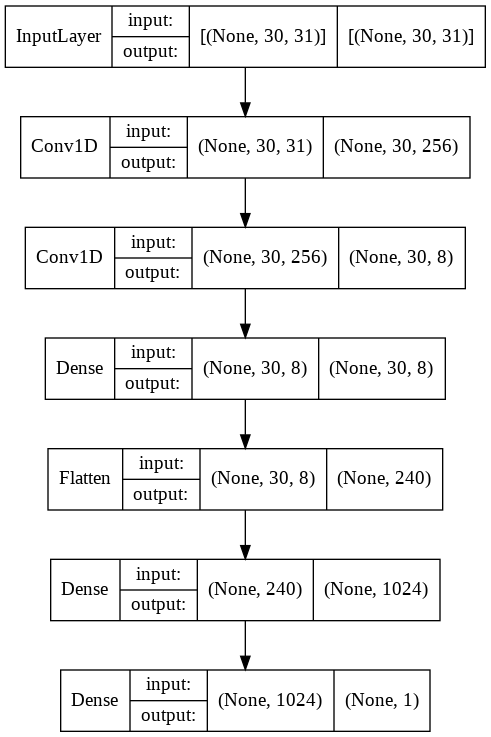

In [20]:
modelT = load_model('/content/drive/MyDrive/ДЗ/diplom/trend/modelT_lag1_00023.h5')
resultsT = modelT.evaluate(valx, valy, batch_size=10)                           # Вывод ошибки по тестовой выборки
print('test loss, test val_loss:', resultsT)
plot_model(modelT, to_file='model_plotT.png', show_shapes=True, show_layer_names=False)

In [ ]:
historyT = modelT.fit(train[0],train[1], # обучающая выборка
                    epochs=100, # количество эпох
                    verbose=1, # визуализация обучения
                    validation_data=(train[2],train[3]), # проверочная выборка
                    callbacks=[earlystopT, reduceLROnPlateauT, model_CheckpointT])  # Callbacks сохранённые зарание 

Epoch 1/100
291/294 [============================>.] - ETA: 0s - loss: 1.0430e-04
Epoch 00001: val_loss did not improve from 0.00023
294/294 [==============================] - 5s 17ms/step - loss: 1.0449e-04 - val_loss: 2.5881e-04 - lr: 2.1600e-05
Epoch 2/100
294/294 [==============================] - ETA: 0s - loss: 1.0137e-04
Epoch 00002: val_loss did not improve from 0.00023
294/294 [==============================] - 5s 18ms/step - loss: 1.0137e-04 - val_loss: 2.3892e-04 - lr: 2.1600e-05
Epoch 3/100
292/294 [============================>.] - ETA: 0s - loss: 1.0044e-04
Epoch 00003: val_loss did not improve from 0.00023
294/294 [==============================] - 5s 18ms/step - loss: 1.0046e-04 - val_loss: 2.3763e-04 - lr: 2.1600e-05
Epoch 4/100
294/294 [==============================] - ETA: 0s - loss: 1.0041e-04
Epoch 00004: val_loss did not improve from 0.00023
294/294 [==============================] - 5s 18ms/step - loss: 1.0041e-04 - val_loss: 2.4621e-04 - lr: 2.1600e-05
Epoch 5/

In [ ]:
plt.plot(historyT.history['loss'],                                              # Вывод графика
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(historyT.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

164/164 [==============================] - 2s 9ms/step - loss: 1.2515e-04
test loss, test val_loss: 0.00012515073467511684


NameError: ignored

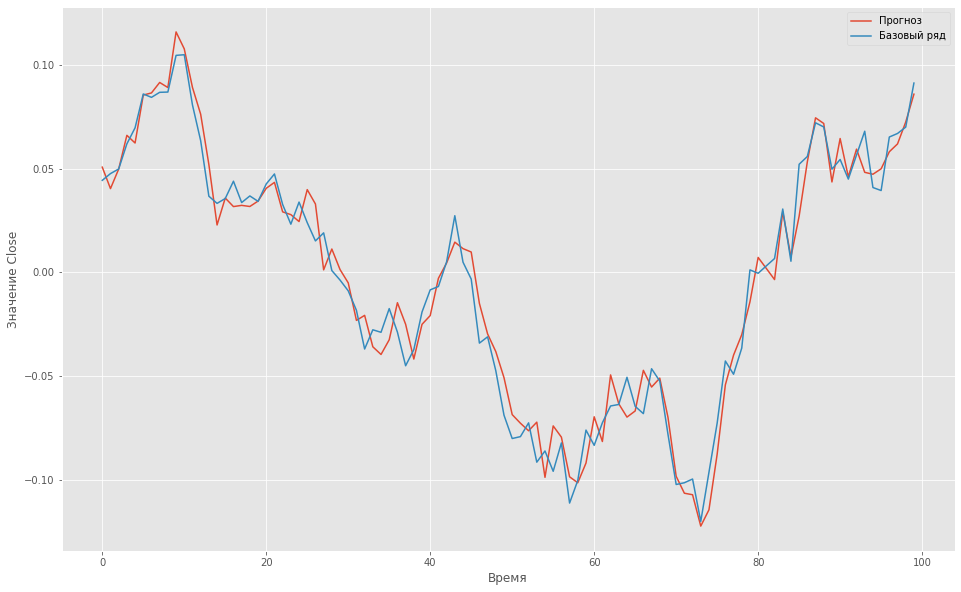

In [21]:
# Прогнозируем данные текущей сетью
(predValT, yValUnscaledT) = get_predT(modelT,valx,valy) #Прогнозируем данные

# Отображаем графики
show_predict(0, 100, 0, predValT, yValUnscaledT)

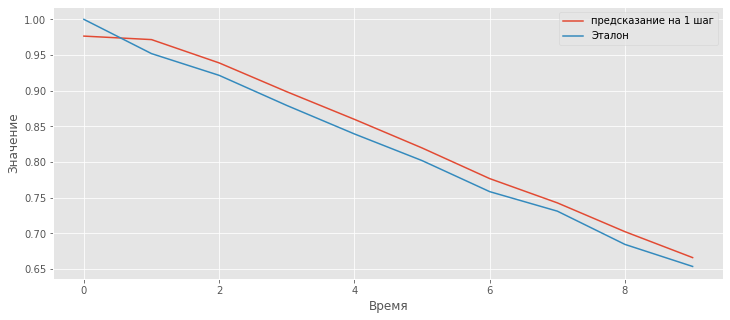

In [22]:
# Отображаем корреляцию
auto_corr([0], 10, predValT, yValUnscaledT)

In [23]:
a15 = valx                                                                      # Вытаскиваем из тестовой выборки входных данных последнее значение перед значение выходных данных
b15 = []                                                                        # для отображение его на график
for i in a15:
  b15.append(i[29][30])
Val15 = modelT.predict(valx)                                                    # Предсказываем значение тренда по тестовой выборки

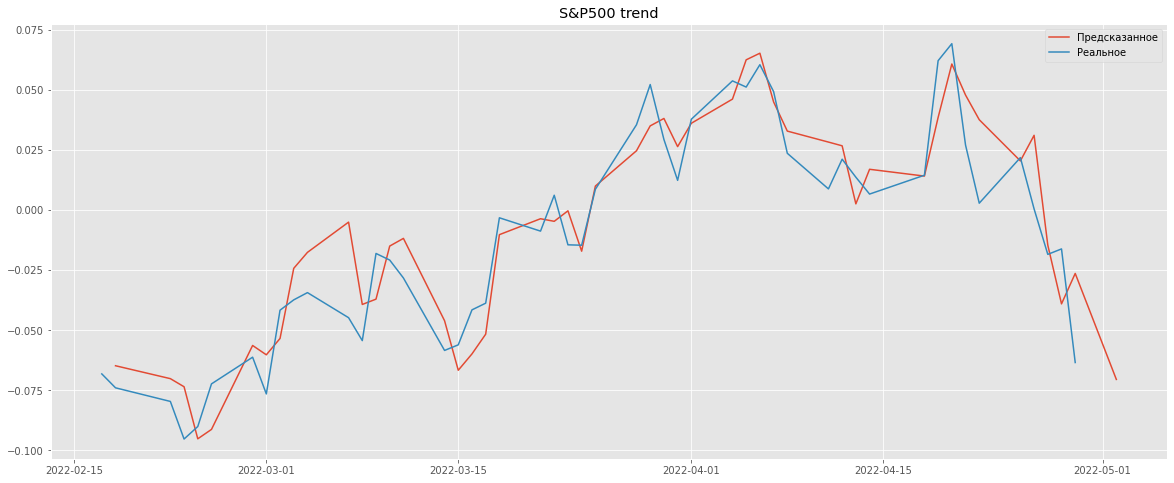

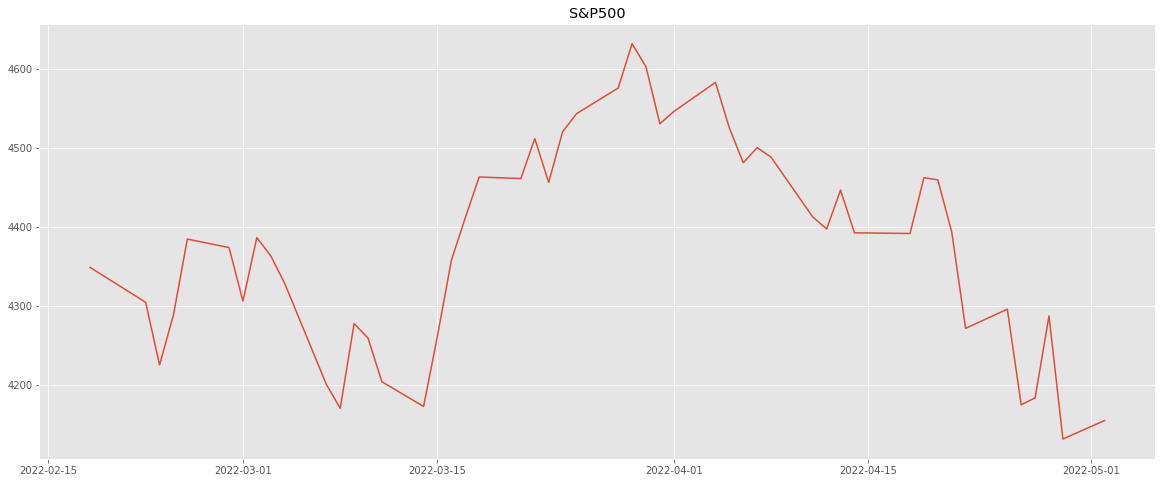

In [24]:
tlen = len(Val15)
i = 50
plt.figure(figsize=(20, 8))
plt.plot(data_org.index[-i:], Val15[-i:], label='Предсказанное')                                       # Вывод предсказанного значения тренда 
plt.plot(data_org.index[-i-1:-1], b15[-i:], label='Реальное')                                     # Вывод последнего значения на входе перед предсказанным 
plt.title('S&P500 trend')
plt.legend()
plt.show()
plt.figure(figsize=(20, 8))
plt.plot(dataVal.index[-i:], dataVal[COL_CLOSE][-i:])                           # Вывод графика цены для сопаставления с трендом
plt.title('S&P500')
plt.show()

Предсказаная цена -0.07376747
Предыдущая цена -0.06895181538804895


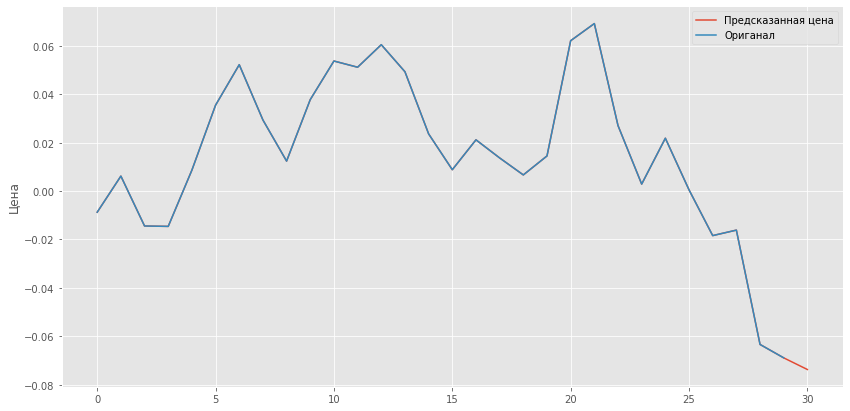

In [25]:
xT = np.reshape((dataTrend[-30:]), (1,30,31))                                   # Выводим график предсказанного тренда наложенного на реальный
predT = modelT.predict(xT)                                                      # На этом графике показана сила тренда, чем дальше от 0 (+/-) тем сильнее тренд
print('Предсказаная цена', predT[0][0])
print('Предыдущая цена', dataTrend[-1:, 30][0])
aT = np.append(dataTrend[-30:,30], predT)
plt.plot(aT, label='Предсказанная цена')
plt.plot(dataTrend[-30:,30], label='Ориганал')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [ ]:
earlystopT1=EarlyStopping(monitor='val_loss',                                     # останавка через 15 эпох если не было изменений на min_delta
                        min_delta=0,
                        patience=15,
                        verbose=1,
                        baseline=None, 
                        restore_best_weights=True)

reduceLROnPlateauT1 = ReduceLROnPlateau(monitor='val_loss',                       # через 4 эпох изменить шаг обучение на factor 0.6
                                      factor=0.6, 
                                      patience=7, 
                                      verbose=1)

model_CheckpointT1 = ModelCheckpoint(filepath='F:\Python\Проект диплом\Модель тренд\modelT1_lag1.h5', 
                                   monitor='val_loss',                           # сохраняем модель лучше предыдущего обучении эпохи по val_loss
                                   verbose=1, 
                                   save_best_only=True,
                                   mode='auto', 
                                   baseline=None)

In [ ]:
bot = popul[1]
print(bot)

modelT1 = create_randnet(bot,                                                    # Создаем модель из второго бота с наименьшей ошибкой в популяции
                        inputShapeT[0],
                        inputShapeT[1],
                        outputShape[0])
modelT1.summary()
modelT1.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse')

164/164 [==============================] - 5s 31ms/step - loss: 1.2105e-04
test loss, test val_loss: 0.00012105440691811964


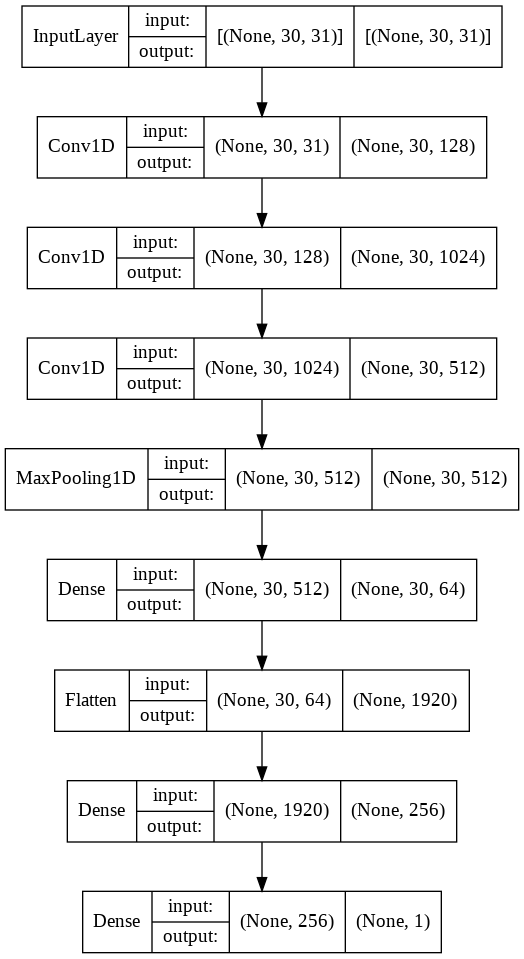

In [26]:
modelT1 = load_model('/content/drive/MyDrive/ДЗ/diplom/trend/modelT1_lag1_000235.h5')
resultsT1 = modelT1.evaluate(valx, valy, batch_size=10)                           # Вывод ошибки по тестовой выборки
print('test loss, test val_loss:', resultsT1)
plot_model(modelT1, to_file='model_plotT1.png', show_shapes=True, show_layer_names=False)

In [ ]:
historyT1 = modelT1.fit(train[0],train[1], # обучающая выборка
                    epochs=100, # количество эпох
                    verbose=1, # визуализация обучения
                    validation_data=(train[2],train[3]), # проверочная выборка
                    callbacks=[earlystopT1, reduceLROnPlateauT1, model_CheckpointT1])  # Callbacks сохранённые зарание 

Epoch 1/100
294/294 [==============================] - ETA: 0s - loss: 9.5304e-04
Epoch 00001: val_loss did not improve from 0.00024
294/294 [==============================] - 132s 448ms/step - loss: 9.5304e-04 - val_loss: 5.3985e-04 - lr: 1.0000e-04
Epoch 2/100
294/294 [==============================] - ETA: 0s - loss: 1.8999e-04
Epoch 00002: val_loss did not improve from 0.00024
294/294 [==============================] - 132s 448ms/step - loss: 1.8999e-04 - val_loss: 4.1436e-04 - lr: 1.0000e-04
Epoch 3/100
294/294 [==============================] - ETA: 0s - loss: 1.7056e-04
Epoch 00003: val_loss did not improve from 0.00024
294/294 [==============================] - 132s 449ms/step - loss: 1.7056e-04 - val_loss: 3.2193e-04 - lr: 1.0000e-04
Epoch 4/100
294/294 [==============================] - ETA: 0s - loss: 1.5141e-04
Epoch 00004: val_loss did not improve from 0.00024
294/294 [==============================] - 133s 452ms/step - loss: 1.5141e-04 - val_loss: 5.0397e-04 - lr: 1.0000e

Epoch 32/100
294/294 [==============================] - ETA: 0s - loss: 6.4678e-05
Epoch 00032: val_loss did not improve from 0.00024
294/294 [==============================] - 134s 456ms/step - loss: 6.4678e-05 - val_loss: 2.8172e-04 - lr: 2.1600e-05
Epoch 33/100
294/294 [==============================] - ETA: 0s - loss: 6.4608e-05
Epoch 00033: val_loss did not improve from 0.00024
294/294 [==============================] - 130s 444ms/step - loss: 6.4608e-05 - val_loss: 3.3589e-04 - lr: 2.1600e-05
Epoch 34/100
294/294 [==============================] - ETA: 0s - loss: 6.5988e-05
Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.2959999367012642e-05.

Epoch 00034: val_loss did not improve from 0.00024
294/294 [==============================] - 130s 442ms/step - loss: 6.5988e-05 - val_loss: 2.8630e-04 - lr: 2.1600e-05
Epoch 35/100
294/294 [==============================] - ETA: 0s - loss: 5.8838e-05
Epoch 00035: val_loss did not improve from 0.00024
294/294 [===================

164/164 [==============================] - 7s 42ms/step - loss: 1.1977e-04
test loss, test val_loss: 0.00011977439862675965


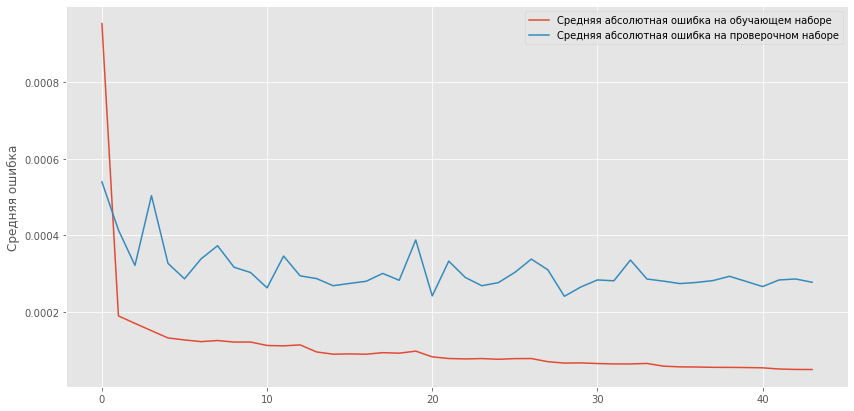

In [ ]:
plt.plot(historyT1.history['loss'],                                              # Вывод графика
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(historyT1.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

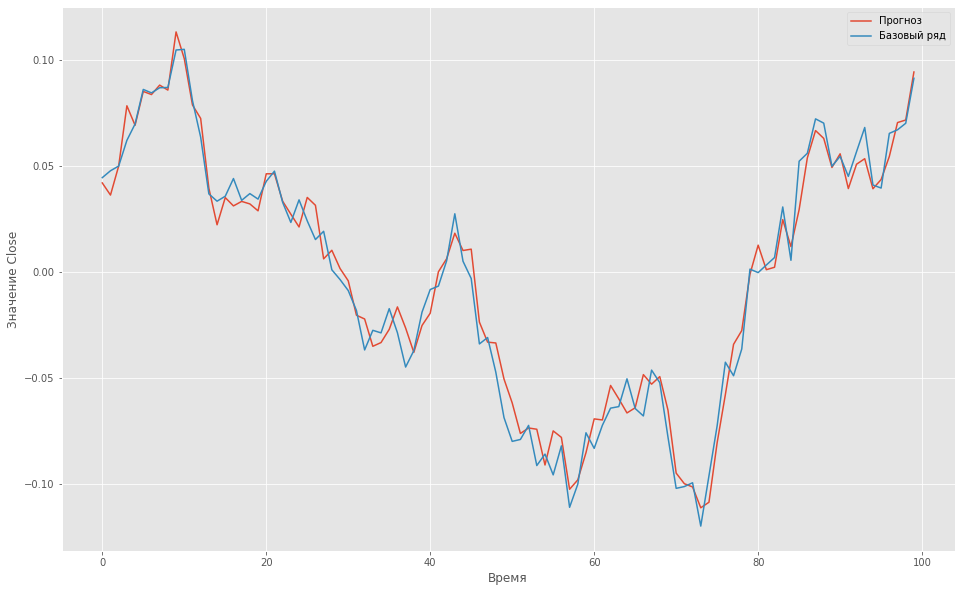

In [27]:
# Прогнозируем данные текущей сетью
(predValT1, yValUnscaledT1) = get_predT(modelT1,valx,valy) #Прогнозируем данные

# Отображаем графики
show_predict(0, 100, 0, predValT1, yValUnscaledT1)

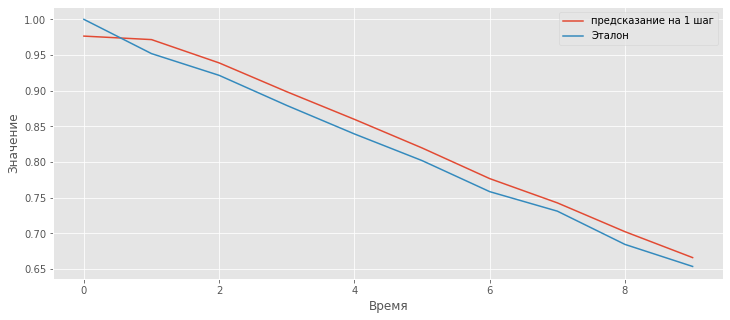

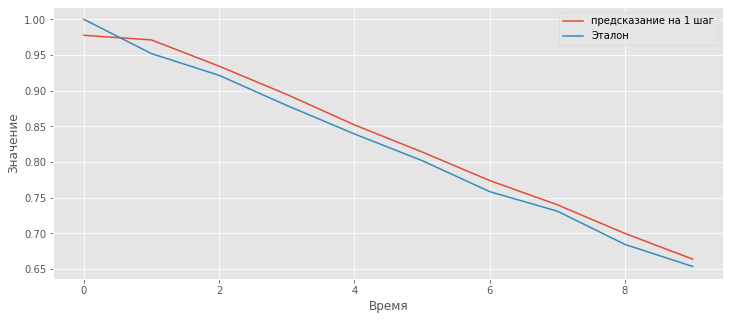

In [28]:
# Отображаем корреляцию
auto_corr([0], 10, predValT, yValUnscaledT)
auto_corr([0], 10, predValT1, yValUnscaledT1)

In [29]:
a15 = valx                                                                      # Вытаскиваем из тестовой выборки входных данных последнее значение перед значение выходных данных
b15 = []                                                                        # для отображение его на график
for i in a15:
  b15.append(i[29][30])
Val151 = modelT1.predict(valx)                                                    # Предсказываем значение тренда по тестовой выборки

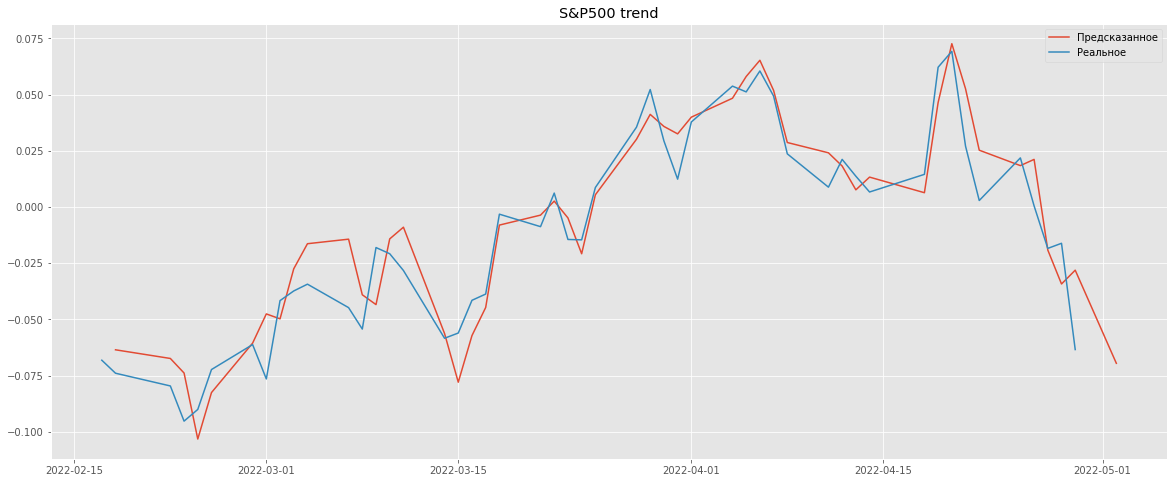

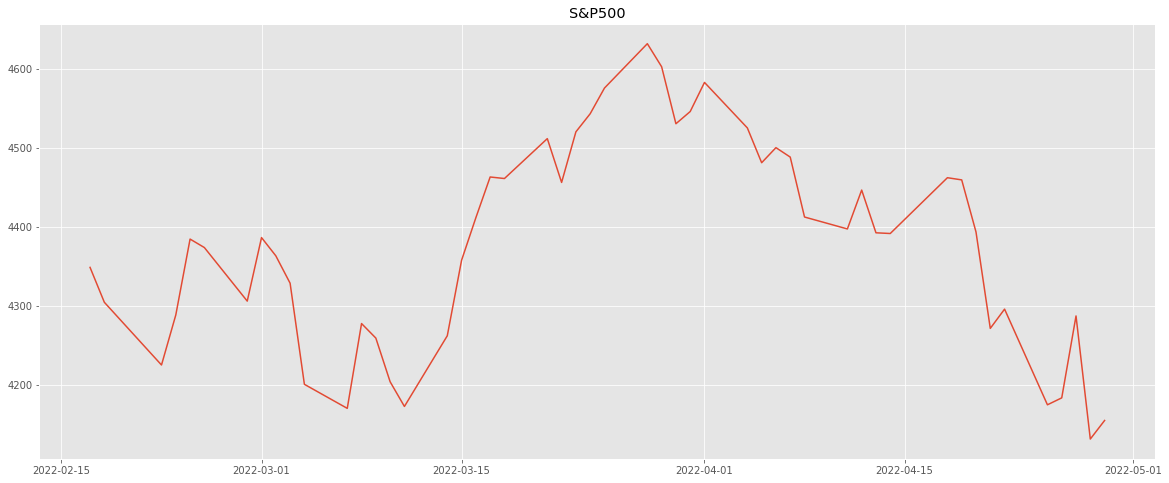

In [30]:
tlen = len(Val151)
i = 50
plt.figure(figsize=(20, 8))                                                      # Вывод графика сопаставления реальньного тренда с предсказаным 
plt.plot(data_org.index[-i:], Val151[-i:], label='Предсказанное')                 # Вывод предсказанного значения тренда 
plt.plot(data_org.index[-i-1:-1], b15[-i:], label='Реальное')                    # Вывод последнего значения на входе перед предсказанным 
plt.title('S&P500 trend')
plt.legend()
plt.show()
plt.figure(figsize=(20, 8))
plt.plot(dataVal.index[-i-1:-1], dataVal[COL_CLOSE][-i:])                           # Вывод графика цены для сопаставления с трендом
plt.title('S&P500')
plt.show()

Предсказаная model -0.07376747
Предсказаная model1 -0.07376747
Предыдущая цена -0.06895181538804895


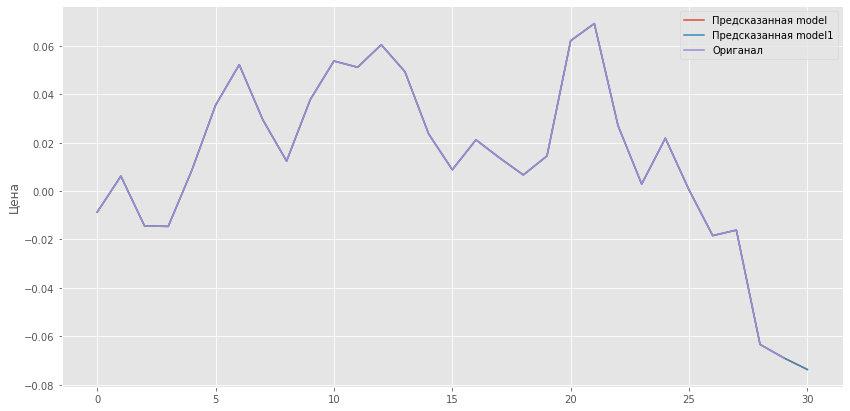

In [31]:
predT1 = modelT.predict(xT)                                                     # Выводим график предсказанного тренда наложенного на реальный
print('Предсказаная model', predT[0][0])                                        # Предсказание нескольких моделей
print('Предсказаная model1', predT1[0][0])                                      # На этом графике показана сила тренда, чем дальше от 0 (+/-) тем сильнее тренд
print('Предыдущая цена', dataTrend[-1:, 30][0])
aT1 = np.append(dataTrend[-30:,30], predT1)
plt.plot(aT, label='Предсказанная model')
plt.plot(aT1, label='Предсказанная model1')
plt.plot(dataTrend[-30:,30], label='Ориганал')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [ ]:
'''
Основные параметры для поиска в модели предсказания цены
'''
n = 25              # Общее число ботов
nsurv = 5           # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 24              # Размер бота
epohs = 15          # количество эпох поиска
control_std = 0.00001 # выход из поиска если изменение в лучших ниже данного значения


'''
Изменении показателя мутации по эпохам поиска
'''
mut = 0.5        # коэфициент мутаций
eph_change_mut = [2,4, 6, 8] # эпохи смены коэфициента мутации
new_mut = [0.4, 0.3, 0.2, 0.1] # новый коэфициент мутаци


'''
Создаём популяцию случайных ботов
'''
popul = []         # Массив популяции
val = []           # Одномерный массив значений этих ботов
for i in range(n):
    popul.append(create_bot4net())


'''
Основной цикл поиска
'''  
sval_best = []    # Одномерный массив значений лучших ботов на эпохах
# Пробегаем по всем эпохам
for it in range(epohs):                 
    # проверяем текущую эпоху it на принадлежность графику смены мутации
    if it in eph_change_mut:
        idx = eph_change_mut.index(it) # получаем индекс  по эпохе
        mut = new_mut[idx] # проверяем текущую эпохуобновляем мутацию
        print('Смена мутации на', mut)
        print()  

    val = []                              # Обнуляем значения бота
    curr_time = time.time()               # засекаем время

    '''
    Получение оценок ботов
    '''  
    # Пробегаем в цикле по всем ботам 
    for i in range(n):                    
        bot = popul[i]                     # Берем очередного бота

        # Вычисляем точность текущего бота
        f = eval_net(bot,            # бот популяции 
            5,              # к-во эпох проверки 
            0,              # выводить или нет процесс обучения 
            trainDataGen,  # тренировочные данные
            testDataGen,    # проверочные данные
            inputShape[0],  # количество подаваемых шагов в наборе
            inputShape[1],  # количество каналов данных в наборе
            yTest.shape[1], # на сколько предсказываем 
            xTest,         # тестовая выборка
            yTest,         # тестовая выборка
            yScaler        # скейлер данных
            ) 
        val.append(f)   # Добавляем полученное значение в список val
    
    '''
    Сортировка оценок ботов и контроль поиса
    ''' 
    sval = sorted(val, reverse=0)         # Сортируем val
    # Выводим 5 лучших ботов
    print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 

    sval_best.append(sval[0])             # добавляем значение лучшего бота
    # проверка на продолжение поиска, есть разница или уже нет в точности
    if it > 7:                            # с 8й эпохи 
        sval_best = sorted(sval_best, reverse=0)[:5] # сортируем и берем 5ть лучших 
        if np.std(sval_best) < control_std:          # сверяем значения на отличие 
            print('Поиск дучших не дает нового, выход')
            break

    '''
    Сохранение лучших ботов в newpopul
    '''  
    newpopul = [] # Создаем пустой список под новую популяцию
    # Пробегаем по всем выжившим ботам
    for i in range(nsurv):
        # Получаем индекс очередного бота из списка лучших в списке val             
        index = val.index(sval[i])
        # Добавляем в новую популяцию бота из popul с индексом index        
        newpopul.append(popul[index])       
    '''
    Создание новых ботов на основе лучших ботов в newpopul.
    Иногда дополнительно применение мутации
    '''
    # Проходимся в цикле nnew-раз 
    for i in range(nnew):
        # случайный выбор родителя в диапазоне от 0 до nsurv - 1              
        indexp1 = random.randint(0,nsurv-1) # Случайный индекс 1го родителя 
        indexp2 = random.randint(0,nsurv-1) # Случайный индекс 1го родителя
        botp1 = newpopul[indexp1]           # бота-родителя 1 по indexp1
        botp2 = newpopul[indexp2]           # бота-родителя  2 по indexp2    
        newbot = []                         # пустой список для нового бота    
        net4Mut = create_bot4net()         # Создаем случайную сеть для мутаций

        '''
        Пробегаем по всей длине бота
        '''
        for j in range(l):                        
            x = 0      

            '''
            Скрещмивание
            '''
            # Получаем случайное число в диапазоне от 0 до 1
            pindex = random.random() 
            # Если pindex меньше 0.5, то берем значения от 1 бота, иначе от 2
            if pindex < 0.5:
                x = botp1[j]
            else:
                x = botp2[j]
            
            '''
            Мутация
            '''
            # С вероятностью mut устанавливаем значение бота из net4Mut
            if (random.random() < mut):
                x = net4Mut[j]
              
            newbot.append(x)    # Добавляем очередное значение в нового бота      
        newpopul.append(newbot) # Добавляем бота в новую популяцию      
    popul = newpopul            # Записываем в popul новую посчитанную популяцию

Обучение модели бота [0, 5, 3, 4, 0, 2, 0, 4, 2, 0, 1, 4, 0, 9, 4, 1, 1, 3, 1, 5, 2, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 4, 2, 1, 1, 1, 0, 3, 3, 0, 4, 2, 1, 6, 3, 1, 1, 3, 1, 8, 3, 7, 1, 0]
Сохранение оценки бота
Обучение модели бота [0, 4, 2, 4, 0, 2, 0, 7, 4, 0, 4, 4, 1, 8, 5, 0, 1, 2, 1, 5, 0, 7, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 1, 2, 1, 4, 2, 1, 2, 4, 1, 9, 3, 1, 2, 1, 0, 5, 1, 7, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 3, 3, 1, 2, 1, 10, 4, 0, 3, 4, 0, 10, 5, 1, 1, 4, 1, 2, 0, 10, 3, 1]
Сохранение оценки бота
Обучение модели бота [0, 3, 2, 1, 0, 3, 0, 8, 3, 1, 2, 3, 1, 10, 5, 1, 1, 1, 1, 3, 0, 7, 4, 1]
Сохранение оценки бота
Обучение модели бота [0, 8, 4, 2, 1, 4, 1, 8, 3, 1, 4, 1, 0, 4, 2, 1, 1, 2, 0, 2, 0, 8, 4, 0]
Сохранение оценки бота
Обучение модели бота [1, 9, 5, 3, 1, 2, 0, 3, 4, 1, 1, 1, 1, 6, 5, 0, 2, 1, 0, 9, 1, 2, 3, 0]
Сохранение оценки бота
Обучение модели бота [1, 5, 4, 1, 1, 4, 0, 10, 2, 0, 2, 0, 0

Сохранение оценки бота
Обучение модели бота [0, 4, 4, 1, 0, 4, 0, 4, 5, 1, 2, 0, 0, 5, 2, 1, 2, 2, 1, 10, 1, 6, 4, 0]
Сохранение оценки бота
Обучение модели бота [0, 4, 4, 0, 1, 3, 1, 6, 3, 0, 4, 0, 1, 8, 2, 1, 2, 2, 0, 8, 0, 4, 2, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 0, 2, 0, 4, 2, 1, 2, 4, 1, 9, 3, 1, 1, 1, 0, 5, 2, 7, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 3, 2, 1, 1, 2, 0, 10, 3, 1, 2, 4, 1, 5, 2, 0, 1, 1, 0, 5, 4, 4, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 4, 4, 1, 0, 3, 0, 9, 2, 1, 2, 0, 0, 4, 5, 1, 1, 2, 1, 2, 1, 3, 4, 0]
Сохранение оценки бота
Обучение модели бота [1, 7, 2, 3, 1, 3, 0, 3, 4, 1, 4, 4, 0, 5, 3, 1, 3, 1, 1, 7, 0, 10, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 9, 3, 1, 0, 4, 0, 8, 4, 0, 3, 2, 1, 4, 2, 1, 1, 2, 1, 3, 0, 8, 1, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 0, 2, 0, 4, 4, 1, 2, 4, 1, 6, 2, 0, 1, 1, 1, 5, 0, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 3, 2, 0, 1, 4

Сохранение оценки бота
Обучение модели бота [0, 3, 2, 1, 0, 2, 1, 6, 5, 0, 1, 3, 1, 5, 5, 1, 3, 4, 0, 5, 0, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 8, 2, 4, 0, 2, 1, 7, 2, 1, 3, 4, 0, 10, 5, 0, 2, 1, 0, 2, 4, 7, 0, 1]
Сохранение оценки бота
Обучение модели бота [0, 7, 5, 1, 0, 2, 0, 7, 2, 1, 2, 4, 0, 9, 2, 1, 1, 1, 1, 8, 2, 6, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 3, 2, 1, 1, 2, 0, 7, 3, 1, 3, 3, 1, 5, 2, 0, 1, 1, 1, 5, 4, 4, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 3, 2, 0, 0, 2, 1, 4, 4, 1, 1, 2, 1, 10, 2, 0, 1, 3, 0, 5, 0, 5, 1, 0]
Сохранение оценки бота
Обучение модели бота [0, 8, 2, 1, 0, 3, 0, 10, 5, 1, 1, 2, 1, 6, 5, 1, 2, 4, 1, 5, 2, 9, 1, 1]
Сохранение оценки бота
Обучение модели бота [0, 9, 2, 1, 0, 2, 0, 8, 2, 1, 2, 4, 1, 8, 3, 1, 1, 1, 1, 6, 0, 7, 0, 1]
Сохранение оценки бота
Обучение модели бота [1, 9, 3, 1, 0, 4, 0, 8, 3, 0, 2, 1, 1, 4, 2, 1, 1, 2, 1, 5, 0, 9, 1, 0]
Сохранение оценки бота
Обучение модели бота [0, 9, 2, 1, 1, 4

Сохранение оценки бота
Обучение модели бота [0, 7, 5, 1, 0, 3, 0, 9, 4, 0, 2, 4, 0, 5, 2, 0, 1, 4, 0, 5, 2, 7, 0, 0]
Сохранение оценки бота
Обучение модели бота [1, 3, 2, 1, 0, 1, 0, 9, 3, 1, 1, 4, 1, 10, 5, 1, 3, 4, 1, 3, 0, 8, 0, 0]
Сохранение оценки бота
6 643.597305059433   [0.00020182669759175238, 0.00021382823677450682, 0.000230959133885707, 0.00026832979268156366, 0.00027475690766935886] [[0, 3, 2, 1, 0, 2, 1, 9, 3, 0, 4, 4, 1, 5, 5, 1, 1, 4, 1, 5, 4, 8, 0, 0], [0, 7, 2, 1, 0, 2, 1, 9, 2, 1, 4, 4, 1, 9, 3, 1, 1, 4, 1, 6, 1, 4, 0, 0], [0, 3, 2, 0, 0, 4, 1, 4, 3, 1, 2, 2, 1, 10, 5, 0, 3, 2, 0, 3, 0, 2, 1, 0], [0, 7, 5, 1, 0, 2, 0, 9, 2, 1, 2, 4, 1, 9, 2, 1, 1, 4, 1, 9, 2, 7, 0, 0], [0, 7, 2, 1, 0, 2, 0, 10, 2, 1, 2, 2, 1, 5, 2, 1, 1, 4, 0, 6, 2, 9, 0, 0]]
Обучение модели бота [0, 7, 2, 2, 0, 1, 1, 9, 2, 1, 2, 0, 1, 5, 2, 1, 1, 4, 0, 6, 1, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 9, 2, 1, 0, 2, 0, 5, 2, 1, 4, 2, 1, 9, 3, 1, 2, 3, 0, 6, 2, 10, 2, 0]
Сохранение оценки

Сохранение оценки бота
Обучение модели бота [0, 9, 2, 0, 0, 2, 1, 10, 2, 0, 4, 4, 1, 9, 4, 1, 2, 4, 0, 6, 2, 10, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 1, 2, 1, 10, 2, 0, 4, 4, 1, 8, 4, 1, 1, 4, 1, 6, 2, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 9, 2, 1, 0, 2, 0, 10, 2, 0, 2, 1, 1, 8, 3, 1, 2, 4, 1, 6, 0, 8, 3, 1]
Сохранение оценки бота
Обучение модели бота [0, 9, 2, 0, 0, 2, 1, 5, 2, 0, 4, 1, 1, 9, 4, 1, 1, 4, 0, 6, 0, 10, 2, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 0, 0, 2, 0, 5, 2, 1, 3, 1, 1, 9, 3, 1, 2, 4, 0, 6, 3, 10, 2, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 4, 1, 0, 2, 1, 8, 2, 0, 2, 4, 1, 8, 4, 0, 1, 3, 0, 6, 0, 5, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 9, 2, 1, 0, 2, 0, 10, 4, 1, 1, 2, 1, 9, 2, 0, 1, 4, 0, 6, 1, 9, 4, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 1, 2, 0, 8, 4, 0, 2, 4, 1, 10, 2, 0, 1, 4, 0, 6, 2, 5, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 9, 4, 1,

Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 0, 2, 1, 10, 2, 0, 1, 0, 1, 8, 2, 0, 1, 4, 0, 6, 3, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 3, 1, 0, 2, 1, 10, 2, 0, 2, 3, 1, 10, 4, 1, 1, 4, 1, 6, 0, 5, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 1, 1, 1, 10, 2, 0, 2, 4, 1, 10, 4, 1, 1, 3, 1, 6, 2, 4, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 3, 1, 0, 2, 1, 10, 2, 0, 1, 3, 1, 10, 4, 1, 1, 3, 1, 6, 0, 8, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 3, 1, 1, 2, 1, 4, 2, 0, 3, 4, 1, 8, 4, 1, 1, 3, 1, 6, 1, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 0, 2, 1, 10, 2, 0, 4, 4, 1, 8, 4, 1, 1, 0, 1, 6, 2, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 1, 2, 1, 4, 2, 0, 2, 4, 1, 8, 4, 1, 1, 4, 1, 6, 2, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [1, 4, 3, 1, 0, 3, 1, 10, 4, 0, 2, 0, 1, 10, 4, 1, 1, 4, 1, 6, 0, 4, 0, 1]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 

Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 0, 2, 1, 10, 2, 0, 2, 3, 1, 9, 4, 1, 1, 4, 1, 6, 0, 8, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 3, 1, 1, 2, 0, 10, 2, 0, 4, 3, 1, 10, 4, 1, 1, 4, 1, 6, 0, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 0, 2, 1, 10, 2, 0, 2, 3, 1, 9, 4, 1, 1, 4, 1, 6, 0, 8, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 1, 2, 1, 10, 2, 0, 2, 4, 1, 8, 4, 1, 1, 2, 1, 6, 2, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 0, 4, 1, 5, 2, 0, 2, 3, 1, 9, 4, 1, 1, 4, 1, 6, 0, 8, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 0, 2, 1, 9, 2, 1, 1, 3, 1, 10, 4, 1, 1, 4, 1, 6, 0, 8, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 0, 2, 1, 9, 2, 0, 2, 4, 1, 9, 4, 1, 1, 4, 0, 6, 0, 9, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 0, 2, 1, 10, 2, 0, 2, 4, 1, 3, 4, 1, 1, 2, 1, 6, 2, 8, 0, 0]
Сохранение оценки бота
Обучение модели бота [0, 7, 2, 1, 

In [ ]:
earlystop=EarlyStopping(monitor='val_loss',                                     # Создание таких же коллбеков как и для тренда только для предсказания цены
                        min_delta=0,
                        patience=15,
                        verbose=1,
                        baseline=None, 
                        restore_best_weights=True)

reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=7, 
                                      verbose=1)

model_Checkpoint = ModelCheckpoint(filepath='F:\Python\Проект диплом\акции\model-lag4.h5', 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True,
                                   mode='auto', 
                                   baseline=None)

In [ ]:
bot = popul[0]
print(bot)

model = create_randnet(bot,                                                     # создание модели для предсказания цены на основание первого бота с нименьшей ошибкой из популяции
                        inputShape[0],
                        inputShape[1],
                        outputShape[0])
model.summary()
model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse')

[0, 7, 2, 1, 0, 2, 1, 10, 2, 1, 1, 3, 1, 10, 4, 1, 1, 4, 1, 6, 0, 8, 0, 0]
Model: "sequential_605"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1387 (Conv1D)        (None, 30, 128)           1408      
                                                                 
 conv1d_1388 (Conv1D)        (None, 30, 1024)          263168    
                                                                 
 max_pooling1d_617 (MaxPooli  (None, 30, 1024)         0         
 ng1D)                                                           
                                                                 
 conv1d_1389 (Conv1D)        (None, 30, 1024)          4195328   
                                                                 
 max_pooling1d_618 (MaxPooli  (None, 30, 1024)         0         
 ng1D)                                                           
                                           

7/7 [==============================] - 0s 36ms/step - loss: 3.4117e-04
test loss, test val_loss: 0.0003411709039937705


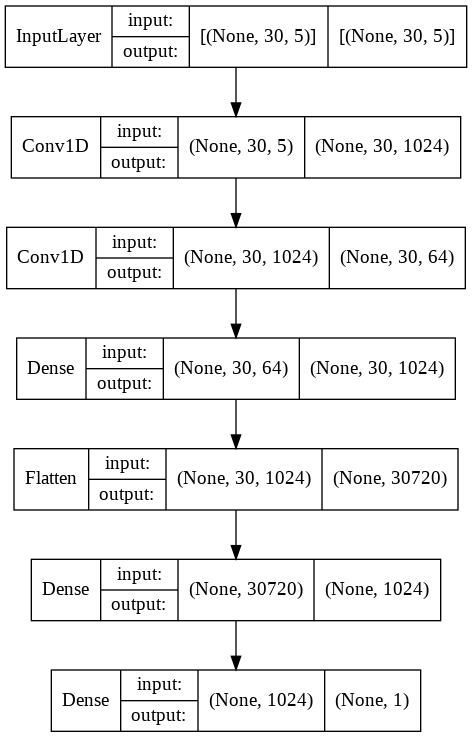

In [32]:
model = load_model('/content/drive/MyDrive/ДЗ/diplom/shares/model-lag4_00021.h5')
results = model.evaluate(xTest, yTest, batch_size=10)                           # Вывод ошибки по тестовой выборки
print('test loss, test val_loss:', results)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
history = model.fit_generator(trainDataGen, # обучающая выборка
                    epochs=100, # количество эпох
                    verbose=1, # визуализация обучения
                    validation_data=testDataGen,
                    callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint]
                    )   

Epoch 1/100
227/227 [==============================] - ETA: 0s - loss: 2.0226e-05
Epoch 00001: val_loss did not improve from 0.00028
227/227 [==============================] - 70s 310ms/step - loss: 2.0226e-05 - val_loss: 3.5385e-04 - lr: 6.0466e-07
Epoch 2/100
227/227 [==============================] - ETA: 0s - loss: 1.7572e-05
Epoch 00002: val_loss did not improve from 0.00028
227/227 [==============================] - 70s 309ms/step - loss: 1.7572e-05 - val_loss: 3.9695e-04 - lr: 6.0466e-07
Epoch 3/100
227/227 [==============================] - ETA: 0s - loss: 1.6985e-05
Epoch 00003: val_loss did not improve from 0.00028
227/227 [==============================] - 70s 309ms/step - loss: 1.6985e-05 - val_loss: 3.4299e-04 - lr: 6.0466e-07
Epoch 4/100
227/227 [==============================] - ETA: 0s - loss: 1.7520e-05
Epoch 00004: val_loss did not improve from 0.00028
227/227 [==============================] - 70s 310ms/step - loss: 1.7520e-05 - val_loss: 4.2554e-04 - lr: 6.0466e-07


1/1 [==============================] - 0s 474ms/step - loss: 9.3550e-04
test loss, test acc: 0.0009354953654110432


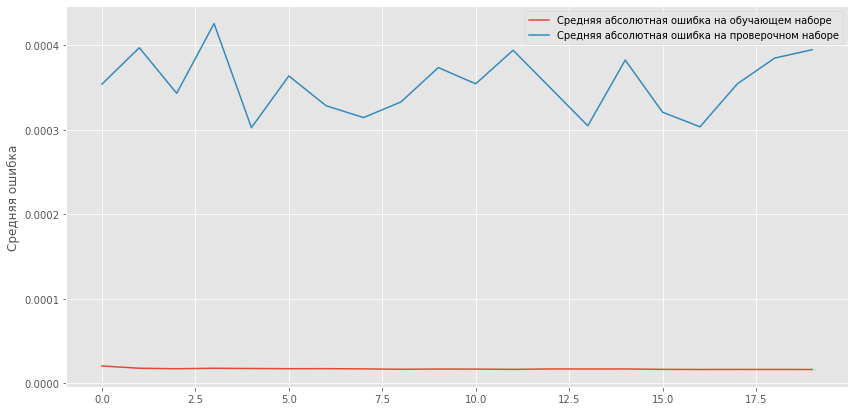

In [ ]:
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

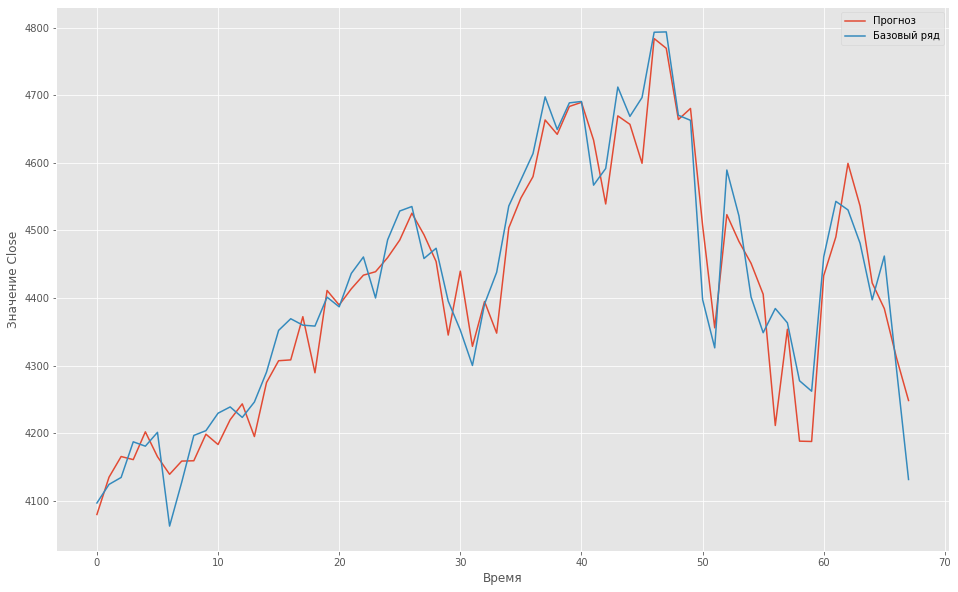

In [33]:
# Прогнозируем данные текущей сетью
(predVal, yValUnscaled) = get_pred(model,xTest,yTest, yScaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 100, 0, predVal, yValUnscaled)

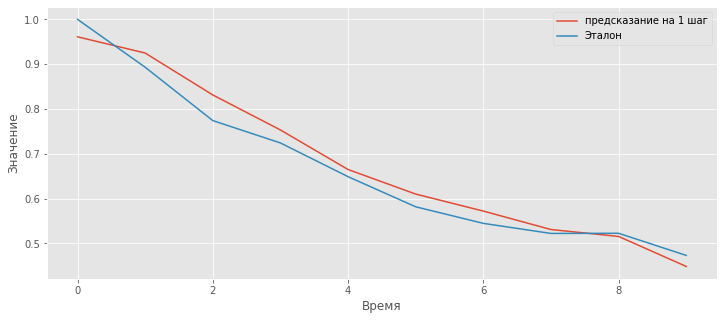

In [34]:
# Отображаем корреляцию
auto_corr([0], 10, predVal, yValUnscaled)

In [35]:
def acc(currModel, # сеть                                                        Функция для сопаставления предсказанной цены с реально полученой
            xVal, # проверочная выборка, экземпляры класса
            yVal, # проверочная выборка, метки класса
            yScaler # правильные ответы в исходной размерности yValUnscaled
            ):
    
  # Предсказание ответа сети по проверочной выборке
  predVal = yScaler.inverse_transform(currModel.predict(xVal))

  # Использование исходного масштаба данных, до нормализации
  yValUnscaled = yScaler.inverse_transform(yVal)

  for i in range(predVal.shape[0]):
    a = (yValUnscaled[i][0]/predVal[i][0])*100 - 100
    print(f"Оригинал: {yValUnscaled[i][0]}, Предсказано: {predVal[i][0]}, Ошибка: {a}%")
  c = np.mean(abs((yValUnscaled/predVal)*100 - 100))
  print(f'Средняя ошибка: {c}%')  
  plt.plot(predVal, 
         label='Предсказанная цена')
  plt.plot(yValUnscaled, 
         label='Реальная цена')
  plt.ylabel('Цена')
  plt.legend()
  plt.show()

Оригинал: 4097.169921875, Предсказано: 4080.172119140625, Ошибка: 0.41659523760372963%
Оригинал: 4124.66015625, Предсказано: 4135.3076171875, Ошибка: -0.2574768777356695%
Оригинал: 4134.93994140625, Предсказано: 4165.87890625, Ошибка: -0.7426755683496395%
Оригинал: 4187.6201171875, Предсказано: 4161.2861328125, Ошибка: 0.6328328198186455%
Оригинал: 4181.169921875, Предсказано: 4202.40234375, Ошибка: -0.5052448608729208%
Оригинал: 4201.6201171875, Предсказано: 4165.6328125, Ошибка: 0.8639096700868976%
Оригинал: 4063.0400390625, Предсказано: 4139.61962890625, Ошибка: -1.8499185120538186%
Оригинал: 4127.830078125, Предсказано: 4159.12939453125, Ошибка: -0.7525449063307548%
Оригинал: 4197.0498046875, Предсказано: 4159.6181640625, Ошибка: 0.8998816513591237%
Оригинал: 4204.10986328125, Предсказано: 4198.90185546875, Ошибка: 0.12403261594973003%
Оригинал: 4229.89013671875, Предсказано: 4183.607421875, Ошибка: 1.1062872343554346%
Оригинал: 4239.18017578125, Предсказано: 4220.2666015625, Ошибк

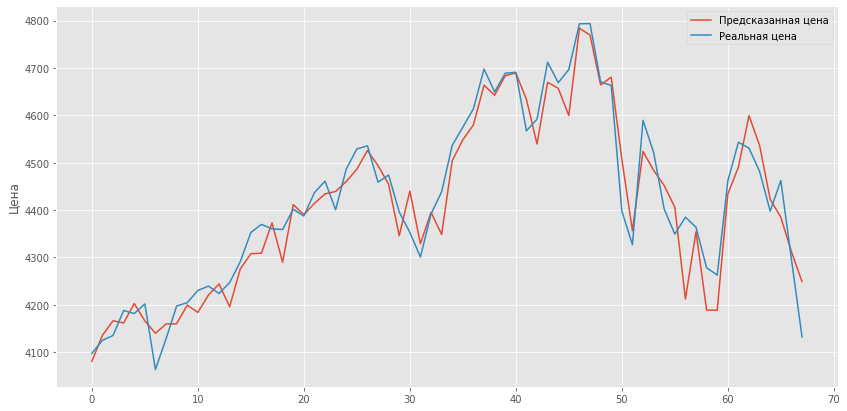

In [36]:
acc(model, xTest, yTest, yScaler)                                               # Высчитываем процент ошибки(день) реальная с предсказанной ценой и средняя ошибка

Предсказаная цена 4125.2876
Предыдущая цена 4155.3798828125


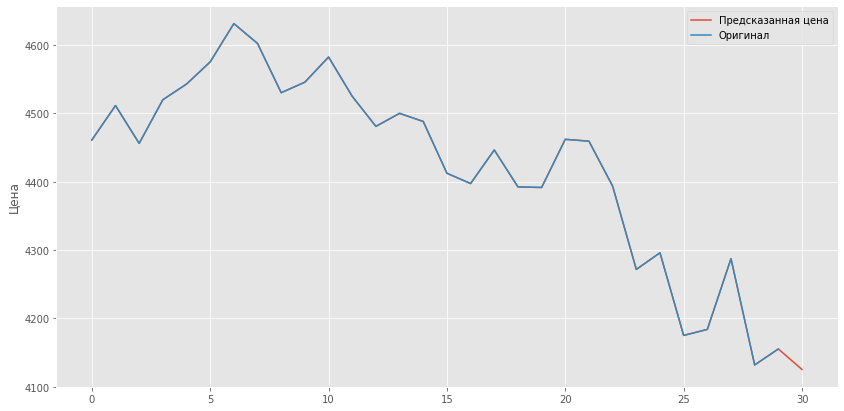

In [37]:
x = np.reshape(xScaler.transform(data[-30:]), (1,30,5))                         # Выводим график предсказанной цены наложенной на реальный
pred = yScaler.inverse_transform(model.predict(x))
print('Предсказаная цена', pred[0][0])
print('Предыдущая цена', data[-1:, 3][0])
a = np.append(data[-30:,3], pred)
plt.plot(a, label='Предсказанная цена')
plt.plot(data[-30:,3], label='Оригинал')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [ ]:
earlystop1=EarlyStopping(monitor='val_loss',                                     # Создание таких же коллбеков как и для тренда только для предсказания цены
                        min_delta=0,
                        patience=15,
                        verbose=1,
                        baseline=None, 
                        restore_best_weights=True)

reduceLROnPlateau1 = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=7, 
                                      verbose=1)

model_Checkpoint1 = ModelCheckpoint(filepath='F:\Python\Проект диплом\акции\model1-lag4.h5', 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True,
                                   mode='auto', 
                                   baseline=None)

In [ ]:
bot = popul[1]
print(bot)

model1 = create_randnet(bot,                                                     # создание модели для предсказания цены на основание первого бота с нименьшей ошибкой из популяции
                        inputShape[0],
                        inputShape[1],
                        outputShape[0])
model1.summary()
model1.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse')
# [0, 10, 5, 2, 0, 1, 1, 9, 4, 0, 1, 2, 1, 10, 4, 0, 2, 4, 0, 4, 2, 5, 4, 0, 0]

[0, 7, 2, 1, 0, 2, 1, 10, 2, 0, 2, 3, 1, 9, 4, 1, 1, 4, 1, 6, 0, 8, 0, 0]
Model: "sequential_606"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1390 (Conv1D)        (None, 30, 128)           1408      
                                                                 
 conv1d_1391 (Conv1D)        (None, 30, 1024)          263168    
                                                                 
 conv1d_1392 (Conv1D)        (None, 30, 512)           2097664   
                                                                 
 max_pooling1d_619 (MaxPooli  (None, 30, 512)          0         
 ng1D)                                                           
                                                                 
 dense_1564 (Dense)          (None, 30, 64)            32832     
                                                                 
 flatten_606 (Flatten)       (None, 1920)   

7/7 [==============================] - 0s 32ms/step - loss: 4.2877e-04
test loss, test val_loss: 0.00042877180385403335


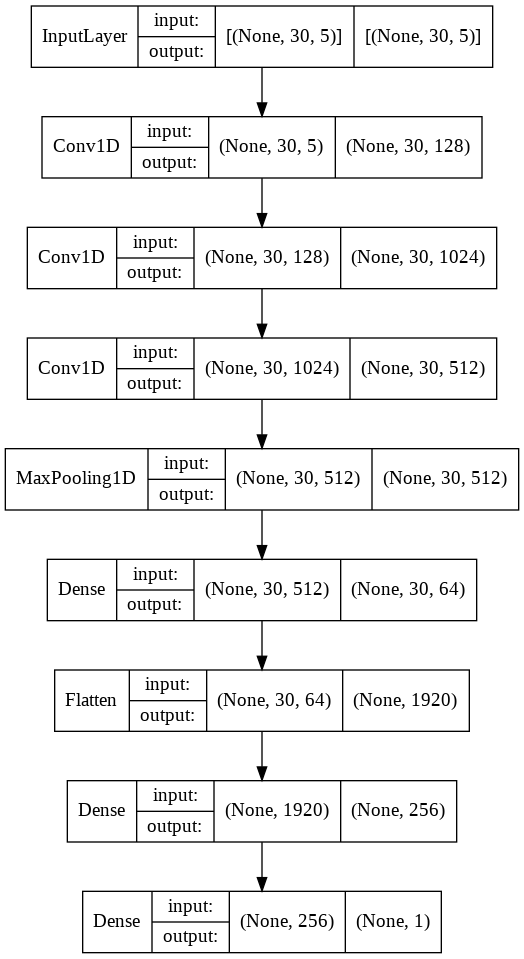

In [38]:
model1 = load_model('/content/drive/MyDrive/ДЗ/diplom/shares/model1-lag4_00029.h5')
results1 = model1.evaluate(xTest, yTest, batch_size=10)                           # Вывод ошибки по тестовой выборки
print('test loss, test val_loss:', results1)
plot_model(model1, to_file='model_plot1.png', show_shapes=True, show_layer_names=False)

In [ ]:
history1 = model1.fit_generator(trainDataGen, # обучающая выборка
                    epochs=100, # количество эпох
                    verbose=1, # визуализация обучения
                    validation_data=testDataGen,
                    callbacks=[earlystop1, reduceLROnPlateau1, model_Checkpoint1]
                    )   

Epoch 1/100
227/227 [==============================] - ETA: 0s - loss: 1.6222e-05
Epoch 00001: val_loss did not improve from 0.00029
227/227 [==============================] - 35s 153ms/step - loss: 1.6222e-05 - val_loss: 3.1850e-04 - lr: 7.8364e-08
Epoch 2/100
227/227 [==============================] - ETA: 0s - loss: 1.6121e-05
Epoch 00002: val_loss did not improve from 0.00029
227/227 [==============================] - 35s 153ms/step - loss: 1.6121e-05 - val_loss: 3.2392e-04 - lr: 7.8364e-08
Epoch 3/100
227/227 [==============================] - ETA: 0s - loss: 1.6149e-05
Epoch 00003: val_loss did not improve from 0.00029
227/227 [==============================] - 35s 154ms/step - loss: 1.6149e-05 - val_loss: 3.1413e-04 - lr: 7.8364e-08
Epoch 4/100
227/227 [==============================] - ETA: 0s - loss: 1.6083e-05
Epoch 00004: val_loss did not improve from 0.00029
227/227 [==============================] - 35s 153ms/step - loss: 1.6083e-05 - val_loss: 3.1006e-04 - lr: 7.8364e-08


1/1 [==============================] - 0s 266ms/step - loss: 6.2035e-04
test loss, test acc: 0.0006203464581631124


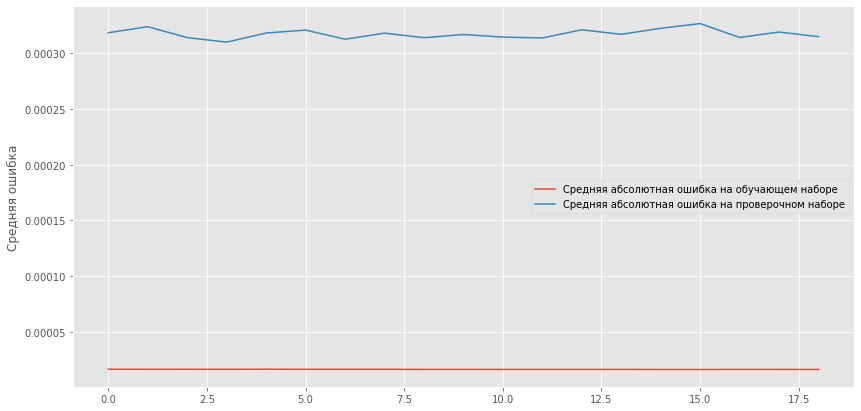

In [ ]:
plt.plot(history1.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history1.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

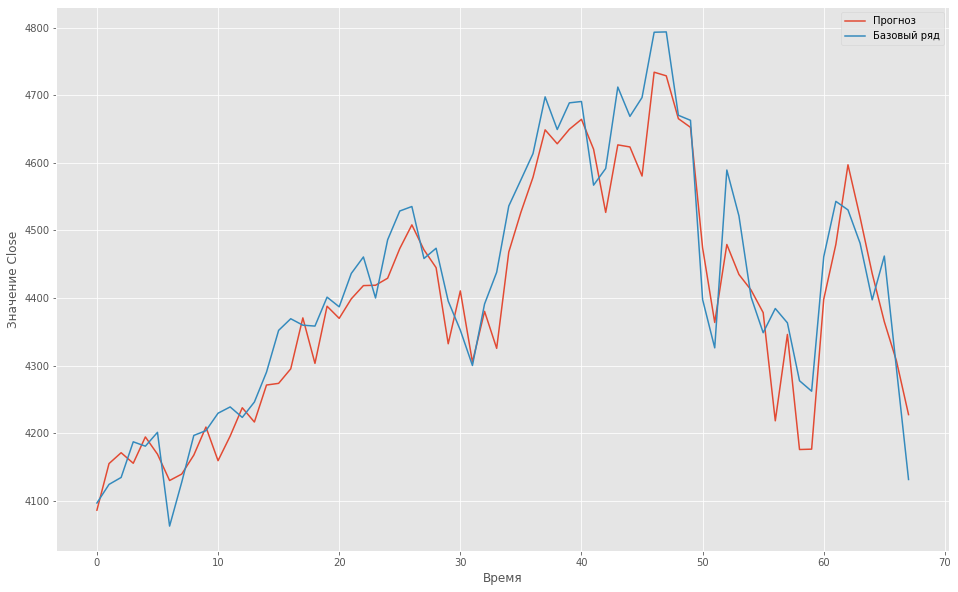

In [39]:
# Прогнозируем данные текущей сетью
(predVal1, yValUnscaled1) = get_pred(model1,xTest,yTest, yScaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 100, 0, predVal1, yValUnscaled1)

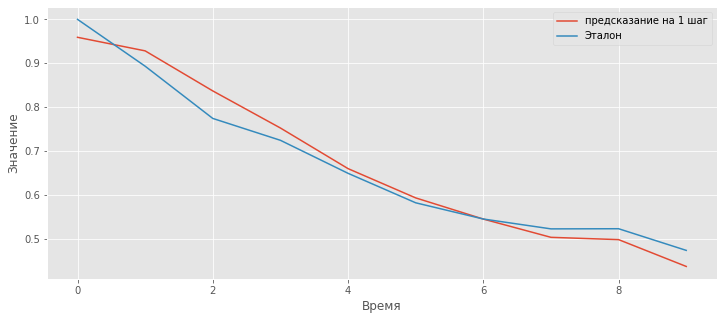

In [40]:
# Отображаем корреляцию
auto_corr([0], 10, predVal1, yValUnscaled1)

Оригинал: 4097.169921875, Предсказано: 4086.5498046875, Ошибка: 0.259879793348361%
Оригинал: 4124.66015625, Предсказано: 4155.4453125, Ошибка: -0.7408389218213358%
Оригинал: 4134.93994140625, Предсказано: 4171.4951171875, Ошибка: -0.8763087275503381%
Оригинал: 4187.6201171875, Предсказано: 4155.9150390625, Ошибка: 0.7628904303142718%
Оригинал: 4181.169921875, Предсказано: 4194.828125, Ошибка: -0.3255962513362789%
Оригинал: 4201.6201171875, Предсказано: 4169.35888671875, Ошибка: 0.7737695733393508%
Оригинал: 4063.0400390625, Предсказано: 4130.4150390625, Ошибка: -1.631192007650938%
Оригинал: 4127.830078125, Предсказано: 4139.89990234375, Ошибка: -0.29154869691213037%
Оригинал: 4197.0498046875, Предсказано: 4167.99658203125, Ошибка: 0.6970548579982534%
Оригинал: 4204.10986328125, Предсказано: 4209.43994140625, Ошибка: -0.12662202571345915%
Оригинал: 4229.89013671875, Предсказано: 4159.7216796875, Ошибка: 1.686854612747112%
Оригинал: 4239.18017578125, Предсказано: 4196.1015625, Ошибка: 1.

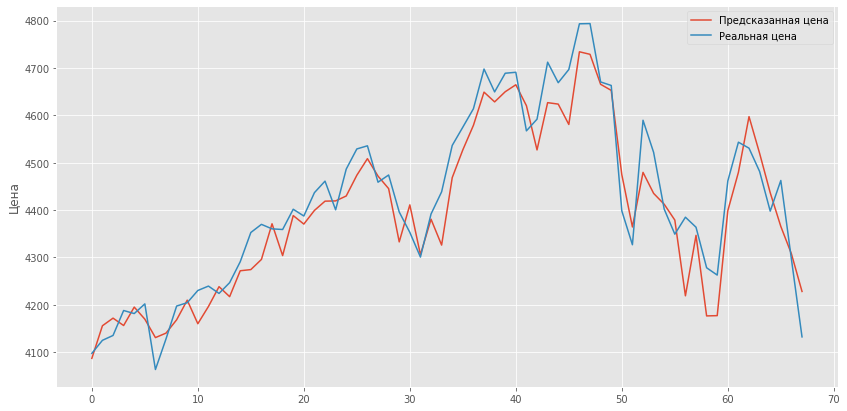

In [41]:
acc(model1, xTest, yTest, yScaler)                                              # Высчитываем процент ошибки(день) реальная с предсказанной ценой и средняя ошибка

Предсказаная цена model1 4120.8203
Предсказаная цена model 4125.2876
Предыдущая цена 4155.3798828125


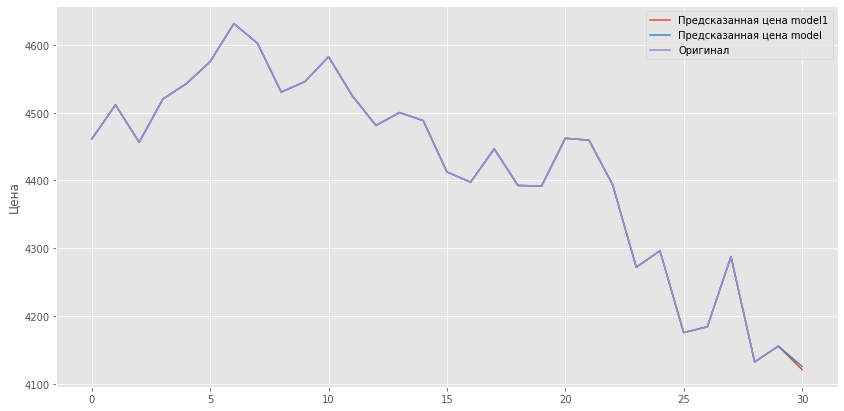

In [42]:
pred1 = yScaler.inverse_transform(model1.predict(x))                            # Выводим график предсказанной цены наложенной на реальный
print('Предсказаная цена model1', pred1[0][0])                                  # Предскуазание нескольких моделей    
print('Предсказаная цена model', pred[0][0])
print('Предыдущая цена', data[-1:, 3][0])
a1 = np.append(data[-30:,3], pred1)
plt.plot(a1, label='Предсказанная цена model1')
plt.plot(a, label='Предсказанная цена model')
plt.plot(data[-30:,3], label='Оригинал')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [ ]:
earlystop2=EarlyStopping(monitor='val_loss',                                     # Создание таких же коллбеков как и для тренда только для предсказания цены
                        min_delta=0,
                        patience=15,
                        verbose=1,
                        baseline=None, 
                        restore_best_weights=True)

reduceLROnPlateau2 = ReduceLROnPlateau(monitor='val_loss', 
                                      factor=0.6, 
                                      patience=7, 
                                      verbose=1)

model_Checkpoint2 = ModelCheckpoint(filepath='F:\Python\Проект диплом\акции\model2-lag4.h5', 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True,
                                   mode='auto', 
                                   baseline=None)

In [ ]:
bot = popul[2]
print(bot)

model2 = create_randnet(bot,                                                     # создание модели для предсказания цены на основание первого бота с нименьшей ошибкой из популяции
                        inputShape[0],
                        inputShape[1],
                        outputShape[0])
model2.summary()
model2.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse')
# [0, 10, 5, 2, 0, 1, 1, 9, 4, 0, 1, 2, 1, 10, 4, 0, 2, 4, 0, 4, 2, 5, 4, 0, 0]

[0, 7, 3, 1, 1, 2, 0, 10, 2, 0, 4, 3, 1, 10, 4, 1, 1, 4, 1, 6, 0, 9, 0, 0]
Model: "sequential_607"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1393 (Conv1D)        (None, 30, 128)           2048      
                                                                 
 max_pooling1d_620 (MaxPooli  (None, 15, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_1394 (Conv1D)        (None, 15, 1024)          525312    
                                                                 
 max_pooling1d_621 (MaxPooli  (None, 15, 1024)         0         
 ng1D)                                                           
                                                                 
 dense_1567 (Dense)          (None, 15, 64)            65600     
                                           

7/7 [==============================] - 0s 11ms/step - loss: 4.0747e-04
test loss, test val_loss: 0.0004074660537298769


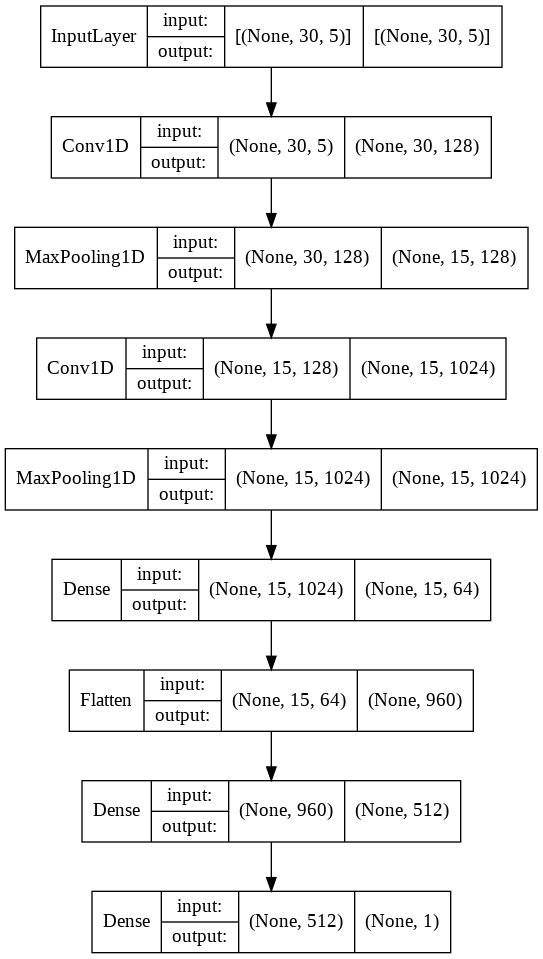

In [43]:
model2 = load_model('/content/drive/MyDrive/ДЗ/diplom/shares/model2-lag4_00031.h5')
results2 = model2.evaluate(xTest, yTest, batch_size=10)                           # Вывод ошибки по тестовой выборки
print('test loss, test val_loss:', results2)
plot_model(model2, to_file='model_plot2.png', show_shapes=True, show_layer_names=False)

In [ ]:
history2 = model2.fit_generator(trainDataGen, # обучающая выборка
                    epochs=100, # количество эпох
                    verbose=1, # визуализация обучения
                    validation_data=testDataGen,
                    callbacks=[earlystop2, reduceLROnPlateau2, model_Checkpoint2]
                    )   

Epoch 1/100
226/227 [============================>.] - ETA: 0s - loss: 2.0171e-05
Epoch 00001: val_loss did not improve from 0.00031
227/227 [==============================] - 9s 41ms/step - loss: 2.0134e-05 - val_loss: 3.3400e-04 - lr: 3.6280e-07
Epoch 2/100
226/227 [============================>.] - ETA: 0s - loss: 1.9995e-05
Epoch 00002: val_loss did not improve from 0.00031
227/227 [==============================] - 9s 41ms/step - loss: 2.0113e-05 - val_loss: 3.2806e-04 - lr: 3.6280e-07
Epoch 3/100
227/227 [==============================] - ETA: 0s - loss: 2.0181e-05
Epoch 00003: val_loss did not improve from 0.00031
227/227 [==============================] - 9s 41ms/step - loss: 2.0181e-05 - val_loss: 3.4961e-04 - lr: 3.6280e-07
Epoch 4/100
226/227 [============================>.] - ETA: 0s - loss: 2.0121e-05
Epoch 00004: val_loss did not improve from 0.00031
227/227 [==============================] - 9s 41ms/step - loss: 2.0090e-05 - val_loss: 3.2846e-04 - lr: 3.6280e-07
Epoch 5/

1/1 [==============================] - 0s 91ms/step - loss: 3.5300e-04
test loss, test acc: 0.00035299849696457386


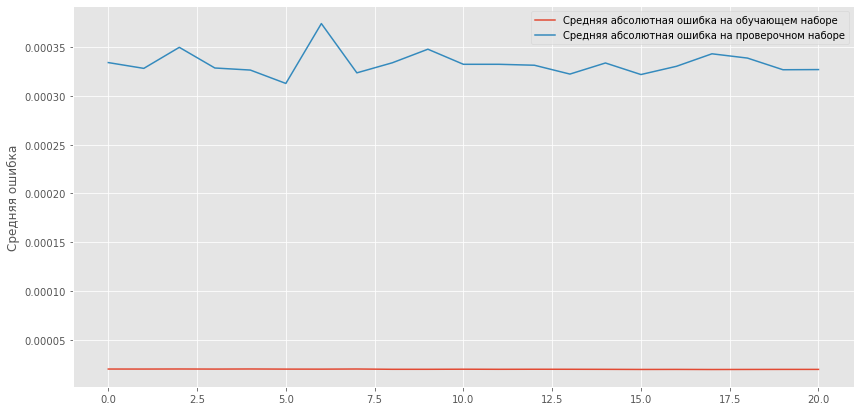

In [ ]:
plt.plot(history2.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history2.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

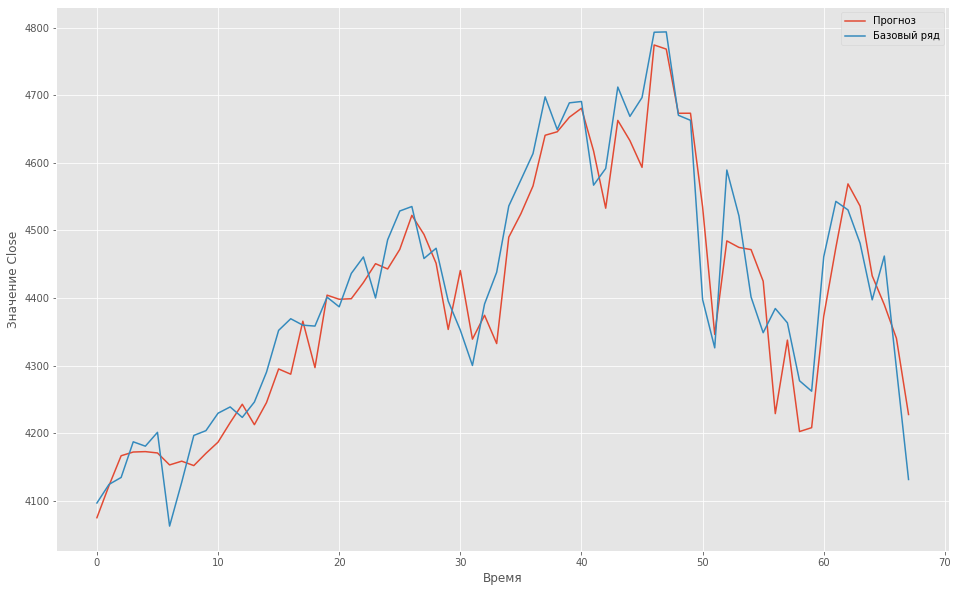

In [44]:
# Прогнозируем данные текущей сетью
(predVal2, yValUnscaled2) = get_pred(model2,xTest,yTest, yScaler) #Прогнозируем данные

# Отображаем графики
show_predict(0, 100, 0, predVal2, yValUnscaled2)

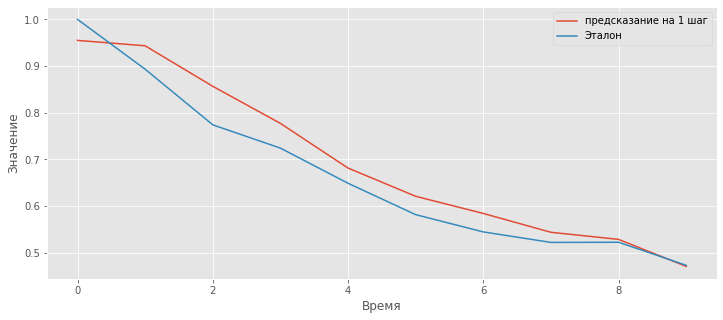

In [45]:
# Отображаем корреляцию
auto_corr([0], 10, predVal2, yValUnscaled2)

Оригинал: 4097.169921875, Предсказано: 4075.415283203125, Ошибка: 0.5338017639953563%
Оригинал: 4124.66015625, Предсказано: 4122.9462890625, Ошибка: 0.04156899137994685%
Оригинал: 4134.93994140625, Предсказано: 4167.01904296875, Ошибка: -0.7698333324545104%
Оригинал: 4187.6201171875, Предсказано: 4172.52978515625, Ошибка: 0.36165906076772103%
Оригинал: 4181.169921875, Предсказано: 4173.1201171875, Ошибка: 0.19289654889985286%
Оригинал: 4201.6201171875, Предсказано: 4171.1416015625, Ошибка: 0.7306996150306304%
Оригинал: 4063.0400390625, Предсказано: 4153.4453125, Ошибка: -2.1766332920147278%
Оригинал: 4127.830078125, Предсказано: 4159.00048828125, Ошибка: -0.7494687784740108%
Оригинал: 4197.0498046875, Предсказано: 4152.47412109375, Ошибка: 1.073472881319475%
Оригинал: 4204.10986328125, Предсказано: 4170.56396484375, Ошибка: 0.8043492132066206%
Оригинал: 4229.89013671875, Предсказано: 4187.1484375, Ошибка: 1.0207829948409852%
Оригинал: 4239.18017578125, Предсказано: 4215.98974609375, Ош

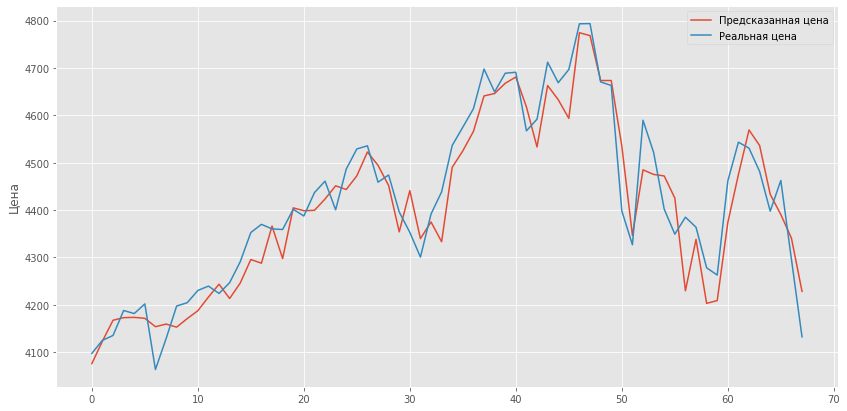

In [46]:
acc(model2, xTest, yTest, yScaler)                                              # Высчитываем процент ошибки(день) реальная с предсказанной ценой и средняя ошибка

Предсказаная цена model2 4147.1685
Предсказаная цена model1 4120.8203
Предсказаная цена model 4125.2876
Предыдущая цена 4155.3798828125


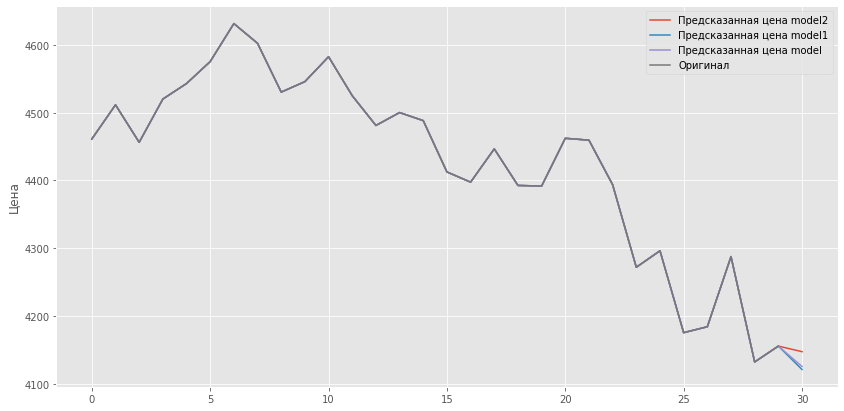

In [47]:
pred2 = yScaler.inverse_transform(model2.predict(x))                            # Выводим график предсказанной цены наложенной на реальный
print('Предсказаная цена model2', pred2[0][0])                                  # Предсказание трех моделей
print('Предсказаная цена model1', pred1[0][0])
print('Предсказаная цена model', pred[0][0])
print('Предыдущая цена', data[-1:, 3][0])
a2 = np.append(data[-30:,3], pred2)
plt.plot(a2, label='Предсказанная цена model2')
plt.plot(a1, label='Предсказанная цена model1')
plt.plot(a, label='Предсказанная цена model')
plt.plot(data[-30:,3], label='Оригинал')
plt.ylabel('Цена')
plt.legend()
plt.show()

Предсказаная model -0.07376747
Предсказаная model1 -0.07376747
Предыдущая цена -0.06895181538804895


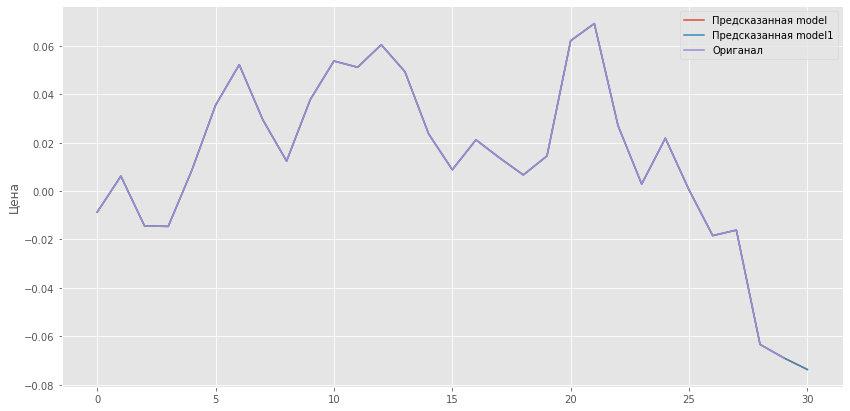

In [48]:
predT1 = modelT.predict(xT)                                                     # Выводим график предсказанного тренда наложенного на реальный
print('Предсказаная model', predT[0][0])                                        # Предсказание нескольких трендов
print('Предсказаная model1', predT1[0][0])                                      # На этом графике показана сила тренда, чем дальше от 0 (+/-) тем сильнее тренд
print('Предыдущая цена', dataTrend[-1:, 30][0])
aT1 = np.append(dataTrend[-30:,30], predT1)
plt.plot(aT, label='Предсказанная model')
plt.plot(aT1, label='Предсказанная model1')
plt.plot(dataTrend[-30:,30], label='Ориганал')
plt.ylabel('Цена')
plt.legend()
plt.show()

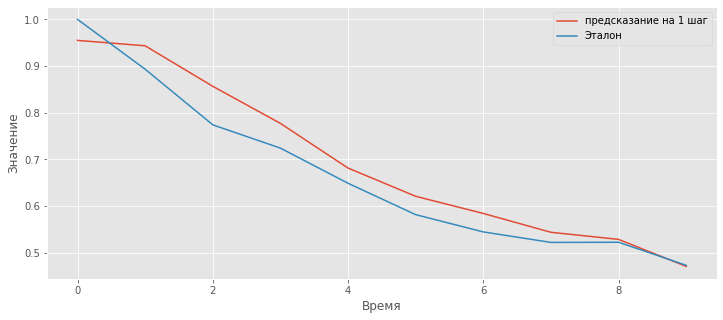

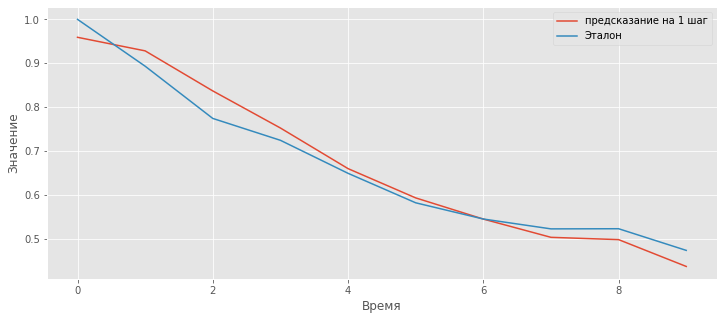

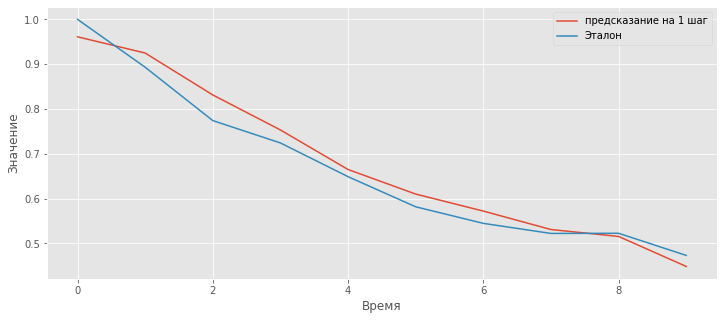

In [49]:
# Отображаем корреляцию трех моделей предсказание цены
auto_corr([0], 10, predVal2, yValUnscaled2)
auto_corr([0], 10, predVal1, yValUnscaled1)
auto_corr([0], 10, predVal, yValUnscaled)

**Вывод:**

Средняя ошибка по предсказанию цены в диапазоне 0.7%-1.4%, при автокрреляции процент ошибки примерно такой же. Автокорреляция уменьшается если брать больше шагов между выборокой(stride). 

При использование этого проекта нужно учитывать все результаты моделей(тренд, цена). Можно наблюдать, если тренд повышающий и предсказывание показывает рост тернда и рост цены, можно предположить, что цена будет расти и на оборот. Также можно заметить что тренд показываеи немного зарание чем цены. Так же при переходе тренда от (-) к (+) и на оборот, тоже можно задуматься от том, что тренд меняется и акцент ставить на этом.